# modelDepthMAN
The flow described in this notebook implements a complete pipeline for evaluating depth estimation and transformation models on the MAN TruckScenes mini dataset, from data preparation to detailed per-image visual analysis.

**Summary of the Flow:**

- **Dataset Acquisition and Preparation:**  
  The pipeline begins by downloading, extracting, and preparing the MAN TruckScenes mini dataset. Images and corresponding LiDAR point clouds are loaded and preprocessed for both training and testing, with the test set reduced for computational efficiency.

- **Relative Depth Estimation:**  
  A pre-trained transformer-based model (Depth-Anything V2) is used to generate relative depth heatmaps for every image in the train and test sets.

- **Affine Parameter Extraction:**  
  For each image, polynomial regression (both linear and quadratic) is used to fit the relationship between relative and absolute depth values, producing the best-fit affine parameters for each sample.

- **Model Definition and Training:**  
  A custom neural network (ScaleBiasHead) is defined, which takes RGB and relative depth as input and predicts affine transformation parameters. The model is trained using a combination of depth and parameter losses, leveraging the polynomial regression results as supervision.

- **Evaluation:**  
  The trained model is evaluated on the test set and compared against the polynomial regression baselines, both globally and under specific lighting conditions. Losses are computed for each approach to quantify performance.

- **Object Detection and Tangible Metrics:**  
  YOLO is used to detect objects and generate bounding boxes in test images. For each detected object, the model’s and polynomial’s depth predictions are compared to LiDAR ground truth, and detailed error metrics are calculated per box, making the evaluation more interpretable and relevant to real-world applications.

- **Visualization and Per-Image Analysis:**  
  Finally, a single test image is randomly selected for in-depth analysis. The notebook displays the image with detected boxes, overlays depth maps and point cloud data, and visualizes the predicted and baseline depth values within each box. Key metrics and errors are reported, providing a concrete, visual, and quantitative understanding of the model’s performance on a real example.

This flow ensures a rigorous, interpretable, and scenario-aware evaluation of depth estimation models, combining classical regression, deep learning, and object detection within a unified framework.

## Dataset
Downloads and unzips the MAN TruckScenes mini dataset (v1.0).

In [1]:
# For v1.0 version of mini dataset
!wget https://man-truckscenes.s3.eu-central-1.amazonaws.com/release/mini/man-truckscenes_metadata_v1.0-mini.zip
!wget https://man-truckscenes.s3.eu-central-1.amazonaws.com/release/mini/man-truckscenes_sensordata_v1.0-mini.zip
!unzip "man-truckscenes_*.zip"

Streaming output truncated to the last 5000 lines.
  inflating: man-truckscenes/sweeps/RADAR_RIGHT_FRONT/RADAR_RIGHT_FRONT_1706716775052244.pcd  
  inflating: man-truckscenes/sweeps/RADAR_RIGHT_FRONT/RADAR_RIGHT_FRONT_1706716775103591.pcd  
  inflating: man-truckscenes/sweeps/RADAR_RIGHT_FRONT/RADAR_RIGHT_FRONT_1706716775154645.pcd  
  inflating: man-truckscenes/sweeps/RADAR_RIGHT_FRONT/RADAR_RIGHT_FRONT_1706716775202114.pcd  
  inflating: man-truckscenes/sweeps/RADAR_RIGHT_FRONT/RADAR_RIGHT_FRONT_1706716775253343.pcd  
  inflating: man-truckscenes/sweeps/RADAR_RIGHT_FRONT/RADAR_RIGHT_FRONT_1706716775351876.pcd  
  inflating: man-truckscenes/sweeps/RADAR_RIGHT_FRONT/RADAR_RIGHT_FRONT_1706716775403897.pcd  
  inflating: man-truckscenes/sweeps/RADAR_RIGHT_FRONT/RADAR_RIGHT_FRONT_1706716775455406.pcd  
  inflating: man-truckscenes/sweeps/RADAR_RIGHT_FRONT/RADAR_RIGHT_FRONT_1706716775501890.pcd  
  inflating: man-truckscenes/sweeps/RADAR_RIGHT_FRONT/RADAR_RIGHT_FRONT_1706716775552976.pcd  

## Downloads of the Requirement

In [2]:
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!pip install truckscenes-devkit[all]
!pip install ultralytics

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.0/71.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.9/386.9 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 45.1 MB/s eta 0:00:00
   ━━━━━

## Imports of the requiremnts

In [1]:
# Standard library
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
import os.path as osp
from datetime import datetime
from typing import Dict, List, Tuple, Union

# ML & data handling
import numpy as np
import torch
import torch.nn.functional as F
import requests
import torch
import torch.nn as nn
import torch.optim as optim
import gc
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms


# Imaging & visualization
import cv2
import matplotlib.pyplot as plt
from matplotlib import cm, rcParams
from matplotlib.axes import Axes
from matplotlib.colors import Colormap, Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.patches as patches

from PIL import Image
import open3d as o3d
from pyquaternion import Quaternion

# TruckScenes devkit
from truckscenes import TruckScenes
from truckscenes.utils import colormap
from truckscenes.utils.data_classes import LidarPointCloud, RadarPointCloud
from truckscenes.utils.geometry_utils import view_points, transform_matrix, BoxVisibility

# Hugging Face Transformers
from transformers import pipeline, AutoImageProcessor, AutoModelForDepthEstimation

#Yolo
from ultralytics import YOLO

from torchvision.transforms import ToTensor



## Utils
Declaration of all the functions needed in the scripts
- **scaleDepthTo255**: Normalizes depth tensor values to 0-255 range and converts to a NumPy array.  
- **scaleDepthTo255n_np**: Performs the same normalization as above but assumes input is already a NumPy array.  
- **scaleDepthToIMG**: Converts a normalized depth tensor to an 8-bit PIL Image object.
- **extract_box_depth_data**: Processes bounding boxes to calculate quadratic-transformed depth metrics and optional absolute depth averages for each box.
- **plot_with_box_depth_rel_abs**: Visualizes an RGB image with bounding boxes, overlays depth statistics, and displays the corresponding transformed depth map with color mapping.
- **plot_with_box_depth**: Displays an RGB image with bounding boxes and mean depth annotations, alongside the corresponding depth map.
- **plot_with_box_depth_3d**: Similar to the above, but uses a quadratic transformation for depth before visualization.
- **map_pointcloud_to_depth**: Projects a point cloud onto a camera image, returning projected points, their colors, the image, and depth values.
- **render_pointcloud_in_deapth**: Retrieves and projects a sample's point cloud onto the camera image, returning points, colors, image, and depths.
- **plot_with_box_depth2**: Plots an RGB image with bounding boxes and mean (linearly transformed) depth annotations on a single axis.
- **plot_with_box_depth3**: Plots an RGB image with bounding boxes and mean (quadratically transformed) depth annotations on a single axis.
- **affine_param_loss**: Computes Huber loss between predicted and target affine parameters (a,b,c) with δ-controlled transition.  
- **affine_depth_loss**: Calculates MSE loss between quadratic-transformed relative depths (a·D² +b·D +c) and absolute depth measurements.  
- **affine_depth_loss_2d**: Computes MSE loss between linearly-transformed relative depths (a·D +b) and absolute depth values.
- **train_in_batches**: Trains a model using RGB-depth batches while optimizing quadratic affine parameters through combined depth-prediction and parameter-proximity losses.  
- **filter_by_lighting**: Extracts test dataset entries matching specific lighting conditions from scene description metadata.  
- **extract_comparison_stats**: Computes error statistics between model-predicted, polynomial-estimated, and ground-truth depth metrics per bounding box.
- **test_yolo_in_batches**: Processes images through YOLO to generate bounding boxes, then compares depth metrics between model-predicted and polynomial-estimated affine parameters for each box.  
- **test_in_batches**: Performs batched inference on RGB-depth inputs to predict affine parameters while evaluating depth transformation accuracy against absolute measurements.
- **plot_stats_vs_num_points**: Plots the distribution of various depth error metrics as a function of the number of LiDAR points per bounding box.
- **plot_comparison_curves**: Creates comparison curves between the trends of the poly and the model, improving the original code with direct comparative visualizations.


In [2]:
def scaleDepthTo255(predicted_depth):
  depth_m = (predicted_depth - predicted_depth.min()) / (predicted_depth.max() - predicted_depth.min())
  depth_m = depth_m.detach().cpu().numpy() * 255
  return depth_m

def scaleDepthTo255n_np(predicted_depth):
  depth_m = (predicted_depth - predicted_depth.min()) / (predicted_depth.max() - predicted_depth.min())
  depth_m = depth_m * 255
  return depth_m

def scaleDepthToIMG(predicted_depth):
  depth_m =  scaleDepthTo255(predicted_depth)
  depth_img = Image.fromarray(depth_m.astype("uint8"))
  return depth_img

In [3]:
def print_comparison_stats(stats):
    print(f"Image Index: {stats.get('image_index', 'N/A')}")
    print(f"poly_vs_abs_stats_mean: {stats.get('poly_vs_abs_stats_mean', 'N/A'):.4f}")
    print(f"model_vs_abs_stats_mean: {stats.get('model_vs_abs_stats_mean', 'N/A'):.4f}")
    print(f"model_vs_poly_stats_mean: {stats.get('model_vs_poly_stats_mean', 'N/A'):.4f}")
    print(f"poly_vs_abs_per_point_stats_mean: {stats.get('poly_vs_abs_per_point_stats_mean', 'N/A'):.6f}")
    print(f"model_vs_abs_per_point_stats_mean: {stats.get('model_vs_abs_per_point_stats_mean', 'N/A'):.6f}")

In [4]:
def extract_box_depth_data(
    depth_rel: np.ndarray,
    input_boxes: np.ndarray,
    a: float,
    b: float = 0.0,
    c: float = 0.0,
    points_dep_abs: np.ndarray = None,
    depths_abs: np.ndarray = None
) -> List[Dict]:

    depth_r = depth_rel.max() - depth_rel
    depth_m = a * depth_r**2 + b * depth_r + c

    # Preprocess punti assoluti (se presenti)
    xs, ys, deps = None, None, None
    if points_dep_abs is not None and depths_abs is not None:
        xs, ys = points_dep_abs[0], points_dep_abs[1]
        valid = (xs >= 0) & (xs < depth_rel.shape[1]) & (ys >= 0) & (ys < depth_rel.shape[0])
        xs, ys, deps = xs[valid], ys[valid], depths_abs[valid]

    results = []

    for box in input_boxes:
        x1, y1, x2, y2 = box.astype(int)

        # Calcola profondità trasformata
        patch = depth_m[y1:y2, x1:x2]
        patch = patch[np.isfinite(patch)]
        transformed = np.nan if patch.size == 0 else np.mean(patch)

        # Inizializza valori assoluti
        absolute, count = None, 0

        # Calcola punti assoluti nel box (se presenti)
        if xs is not None:
            in_box = (xs >= x1) & (xs <= x2) & (ys >= y1) & (ys <= y2)
            count = in_box.sum()
            if count > 0:
                absolute = np.mean(deps[in_box])

        results.append({
            'box': (int(x1), int(y1), int(x2), int(y2)),
            'transformed_depth_mean': float(transformed),
            'absolute_depth_mean': float(absolute) if absolute is not None else None,
            'num_points': int(count)
        })

    return results


In [5]:
def plot_with_box_depth_rel_abs(image: np.ndarray,
                        depth_rel: np.ndarray,
                        input_boxes: np.ndarray,
                        a: float,
                        b: float = 0.0,
                        c: float = 0.0,
                        points_dep_abs=None,
                        depths_abs=None,
                        mask_alpha: float = 0.3,
                        text_color: str = "yellow",
                        box_color: str = "cyan",
                        abs_points_color: str = "red",
                        cmap_depth: str = "plasma"):

    fig, (ax_img, ax_depth) = plt.subplots(1, 2, figsize=(16, 7))

    depth_r = depth_rel.max() - depth_rel
    depth_m = a * depth_r**2 + b * depth_r + c
    depth_m_255 = scaleDepthTo255n_np(depth_m)  # Assumo sia la tua funzione di scaling

    ax_img.imshow(image)
    ax_img.axis('off')
    ax_img.set_title("RGB with Boxes & Depth Information")

    # Visualizza solo punti che cadono in almeno una box
    if points_dep_abs is not None and depths_abs is not None:
        xs, ys = points_dep_abs[0], points_dep_abs[1]
        valid_indices = (xs >= 0) & (xs < depth_rel.shape[1]) & (ys >= 0) & (ys < depth_rel.shape[0])
        xs, ys = xs[valid_indices], ys[valid_indices]
        depths_abs = depths_abs[valid_indices]

        # Usa un array per marcare quali punti sono in almeno una box
        points_in_any_box = np.zeros_like(xs, dtype=bool)
        for box in input_boxes:
            x1, y1, x2, y2 = box.astype(int)
            points_in_box = ((xs >= x1) & (xs <= x2) &
                            (ys >= y1) & (ys <= y2))
            points_in_any_box = points_in_any_box | points_in_box

        # Visualizza solo i punti che sono in almeno una box
        ax_img.scatter(xs[points_in_any_box], ys[points_in_any_box],
                      c=abs_points_color, s=30, alpha=0.8,
                      label='Absolute Depth Points (in boxes)')

        for box in input_boxes:
            x1, y1, x2, y2 = box.astype(int)

            # Calcola profondità media dal depth map trasformato
            patch = depth_m[y1:y2, x1:x2]
            patch = patch[np.isfinite(patch)]
            dist_med = np.nan if patch.size == 0 else np.mean(patch)

            # Disegna box semi-trasparente
            rect = patches.Rectangle((x1, y1),
                                    x2 - x1,
                                    y2 - y1,
                                    linewidth=2,
                                    edgecolor=box_color,
                                    facecolor=box_color,
                                    alpha=mask_alpha)
            ax_img.add_patch(rect)

            # Testo base per profondità trasformata
            text_lines = [f"Transformed: {dist_med:.2f} m"]

            # Controlla punti di distanza assoluta nel box
            if points_dep_abs is not None and depths_abs is not None:
                # Qui xs, ys e depths_abs sono già filtrati e validi
                points_in_box = ((xs >= x1) & (xs <= x2) &
                                (ys >= y1) & (ys <= y2))
                if np.any(points_in_box):
                    abs_depths_in_box = depths_abs[points_in_box]
                    mean_abs_depth = np.mean(abs_depths_in_box)
                    num_points = np.sum(points_in_box)
                    text_lines.append(f"Absolute: {mean_abs_depth:.2f} m ({num_points} pts)\n\n")

            # Combina le linee di testo
            text_content = "\n".join(text_lines)

            # STAMPA SU CONSOLE
            print(f"Box at ({x1},{y1})-({x2},{y2}):\n{text_content}")

            # Annotazione con tutte le informazioni
            ax_img.text(x1, y1 - 5,
                      text_content,
                      color=text_color,
                      fontsize=10,
                      weight='bold',
                      bbox=dict(facecolor='black', alpha=0.6, pad=2),
                      verticalalignment='top')


            # Aggiungi legenda se ci sono punti assoluti
            if points_dep_abs is not None and depths_abs is not None:
                ax_img.legend(loc='upper right')

    # === Destra: Mappa di profondità ===
    im = ax_depth.imshow(depth_m_255,
                        cmap=cmap_depth,
                        vmin=depth_m_255.min(),
                        vmax=depth_m_255.max())
    ax_depth.axis('off')
    ax_depth.set_title("Transformed Depth Map")

    # Aggiungi colorbar
    plt.colorbar(im, ax=ax_depth, shrink=0.8)

    plt.tight_layout()
    plt.show()


In [6]:
np.random.seed(3)

def plot_with_box_depth(image: np.ndarray,
                        depth_rel: np.ndarray,
                        input_boxes: np.ndarray,
                        a: float,
                        b: float = 0.0,
                        mask_alpha: float = 0.3,
                        text_color: str = "yellow",
                        box_color: str = "cyan",
                        cmap_depth: str = "plasma"):

    # Prepare figure and axes
    fig, (ax_img, ax_depth) = plt.subplots(1, 2, figsize=(16, 7))

    depth_r = depth_rel.max() - depth_rel
    depth_m = a * depth_r + b
    depth_m_255 = scaleDepthTo255n_np(depth_m)



    # === Left: RGB + boxes + mean depth annotation ===
    ax_img.imshow(image)
    ax_img.axis('off')
    ax_img.set_title("RGB with Boxes & Mean Depth")

    for box in input_boxes:
        x1, y1, x2, y2 = box.astype(int)

        # Compute mean depth inside box
        patch = depth_m[y1:y2, x1:x2]
        patch = patch[np.isfinite(patch)]
        dist_med = np.nan if patch.size == 0 else np.mean(patch)

        # Draw semi-transparent box
        rect = patches.Rectangle((x1, y1),
                                 x2 - x1,
                                 y2 - y1,
                                 linewidth=2,
                                 edgecolor=box_color,
                                 facecolor=box_color,
                                 alpha=mask_alpha)
        ax_img.add_patch(rect)

        # Annotate mean depth
        ax_img.text(x1, y1 - 5,
                    f"{dist_med:.2f} m",
                    color=text_color,
                    fontsize=12,
                    weight='bold',
                    bbox=dict(facecolor='black', alpha=0.4, pad=2))

    # === Right: Depth map ===
    im = ax_depth.imshow(depth_m_255,
                         cmap=cmap_depth,
                         vmin=depth_m_255.min(),
                         vmax=depth_m_255.max())
    ax_depth.axis('off')
    ax_depth.set_title("Depth Map")

    plt.tight_layout()
    plt.show()

def plot_with_box_depth_3d(image: np.ndarray,
                        depth_rel: np.ndarray,
                        input_boxes: np.ndarray,
                        a: float,
                        b: float = 0.0,
                        c: float = 0.0,
                        mask_alpha: float = 0.3,
                        text_color: str = "yellow",
                        box_color: str = "cyan",
                        cmap_depth: str = "plasma"):

    # Prepare figure and axes
    fig, (ax_img, ax_depth) = plt.subplots(1, 2, figsize=(16, 7))

    depth_r = depth_rel.max() - depth_rel
    depth_m = a * depth_r**2 + b * depth_r + c
    depth_m_255 = scaleDepthTo255n_np(depth_m)



    # === Left: RGB + boxes + mean depth annotation ===
    ax_img.imshow(image)
    ax_img.axis('off')
    ax_img.set_title("RGB with Boxes & Mean Depth")

    for box in input_boxes:
        x1, y1, x2, y2 = box.astype(int)

        # Compute mean depth inside box
        patch = depth_m[y1:y2, x1:x2]
        patch = patch[np.isfinite(patch)]
        dist_med = np.nan if patch.size == 0 else np.mean(patch)

        # Draw semi-transparent box
        rect = patches.Rectangle((x1, y1),
                                 x2 - x1,
                                 y2 - y1,
                                 linewidth=2,
                                 edgecolor=box_color,
                                 facecolor=box_color,
                                 alpha=mask_alpha)
        ax_img.add_patch(rect)

        # Annotate mean depth
        ax_img.text(x1, y1 - 5,
                    f"{dist_med:.2f} m",
                    color=text_color,
                    fontsize=12,
                    weight='bold',
                    bbox=dict(facecolor='black', alpha=0.4, pad=2))

    # === Right: Depth map ===
    im = ax_depth.imshow(depth_m_255,
                         cmap=cmap_depth,
                         vmin=depth_m_255.min(),
                         vmax=depth_m_255.max())
    ax_depth.axis('off')
    ax_depth.set_title("Depth Map")

    plt.tight_layout()
    plt.show()




def map_pointcloud_to_depth(pointsensor_token: str,
                                camera_token: str,
                                min_dist: float = 1.0,
                                render_intensity: bool = False,
                                cmap: str = 'viridis',
                                cnorm: bool = True) -> Tuple:


        cam = trucksc.get('sample_data', camera_token)
        pointsensor = trucksc.get('sample_data', pointsensor_token)
        pcl_path = osp.join(trucksc.dataroot, pointsensor['filename'])
        if pointsensor['sensor_modality'] == 'lidar':
            pc = LidarPointCloud.from_file(pcl_path)
        else:
            pc = RadarPointCloud.from_file(pcl_path)
        im = Image.open(osp.join(trucksc.dataroot, cam['filename']))

        cs_record = trucksc.get('calibrated_sensor', pointsensor['calibrated_sensor_token'])
        pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix)
        pc.translate(np.array(cs_record['translation']))

        poserecord = trucksc.get('ego_pose', pointsensor['ego_pose_token'])
        pc.rotate(Quaternion(poserecord['rotation']).rotation_matrix)
        pc.translate(np.array(poserecord['translation']))

        poserecord = trucksc.get('ego_pose', cam['ego_pose_token'])
        pc.translate(-np.array(poserecord['translation']))
        pc.rotate(Quaternion(poserecord['rotation']).rotation_matrix.T)

        cs_record = trucksc.get('calibrated_sensor', cam['calibrated_sensor_token'])
        pc.translate(-np.array(cs_record['translation']))
        pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix.T)

        depths = pc.points[2, :]

        if render_intensity:
            if pointsensor['sensor_modality'] == 'lidar':
                coloring = pc.points[3, :]
            else:
                coloring = pc.points[6, :]
        else:
            coloring = depths

        if cnorm:
            norm = Normalize(vmin=np.quantile(coloring, 0.5),
                             vmax=np.quantile(coloring, 0.95), clip=True)
        else:
            norm = None
        mapper = ScalarMappable(norm=norm, cmap=cmap)
        coloring = mapper.to_rgba(coloring)[..., :3]

        points = view_points(pc.points[:3, :], np.array(cs_record['camera_intrinsic']),
                             normalize=True)


        mask = np.ones(depths.shape[0], dtype=bool)
        mask = np.logical_and(mask, depths > min_dist)
        mask = np.logical_and(mask, points[0, :] > 1)
        mask = np.logical_and(mask, points[0, :] < im.size[0] - 1)
        mask = np.logical_and(mask, points[1, :] > 1)
        mask = np.logical_and(mask, points[1, :] < im.size[1] - 1)

        points = points[:, mask]
        coloring = coloring[mask, :]
        depths = depths[mask]

        return points, coloring, im , depths

def render_pointcloud_in_deapth(
                                   sample_token: str,
                                   pointsensor_channel: str = 'LIDAR_LEFT',
                                   camera_channel: str = 'CAMERA_LEFT_FRONT',
                                   render_intensity: bool = False,
                                   cmap: str = 'viridis'):



        sample_record = trucksc.get('sample', sample_token)

        pointsensor_token = sample_record['data'][pointsensor_channel]
        camera_token = sample_record['data'][camera_channel]

        points, coloring, im, depth = map_pointcloud_to_depth(pointsensor_token, camera_token,
                                                            render_intensity=render_intensity,
                                                            cmap=cmap)

        return points, coloring, im, depth


def show_anns_on_ax(anns: List[Dict], ax: plt.Axes, borders: bool = True):
    if not anns:
        return
    sorted_anns = sorted(anns, key=lambda x: x['area'], reverse=True)

    h, w = sorted_anns[0]['segmentation'].shape
    overlay = np.zeros((h, w, 4), dtype=float)

    for ann in sorted_anns:
        m = ann['segmentation'].astype(bool)
        color = np.concatenate([np.random.rand(3), [0.5]])  # rgba
        overlay[m] = color

        if borders:
            # Estrai i contorni e li disegna
            contours, _ = cv2.findContours(
                m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE
            )
            smooth = [cv2.approxPolyDP(c, 0.01 * cv2.arcLength(c, True), True)
                      for c in contours]
            cv2.drawContours(overlay, smooth, -1, (0,0,1,0.8), 1)

    ax.imshow(overlay)


def plot_with_box_depth2(image: np.ndarray,
                        depth_rel: np.ndarray,
                        input_boxes: np.ndarray,
                        a: float,
                        b: float = 0.0,
                        mask_alpha: float = 0.3,
                        text_color: str = "yellow",
                        box_color: str = "cyan"):


    # Calibro la profondità

    depth_r = depth_rel.max() - depth_rel

    depth_m = a * depth_r + b

    # Preparo figura ad un solo asse
    fig, ax = plt.subplots(1, 1, figsize=(16, 12))
    ax.imshow(image)
    ax.axis('off')
    ax.set_title("RGB with Boxes & Mean Depth")

    for box in input_boxes:
        x1, y1, x2, y2 = box.astype(int)

        # Calcolo distanza media nel box
        patch = depth_m[y1:y2, x1:x2]
        patch = patch[np.isfinite(patch)]
        dist_med = np.nan if patch.size == 0 else np.mean(patch)

        # Disegno box semi‐trasparente
        rect = patches.Rectangle((x1, y1),
                                 x2 - x1,
                                 y2 - y1,
                                 linewidth=2,
                                 edgecolor=box_color,
                                 facecolor=box_color,
                                 alpha=mask_alpha)
        ax.add_patch(rect)

        # Annotazione distanza
        ax.text(x1, y1 - 5,
                f"{dist_med:.2f} m",
                color=text_color,
                fontsize=12,
                weight='bold',
                bbox=dict(facecolor='black', alpha=0.4, pad=2))

    plt.tight_layout()
    plt.show()

def plot_with_box_depth3(image: np.ndarray,
                        depth_rel: np.ndarray,
                        input_boxes: np.ndarray,
                        a: float,
                        b: float = 0.0,
                        c: float = 0.0,
                        mask_alpha: float = 0.3,
                        text_color: str = "yellow",
                        box_color: str = "cyan"):


    # Calibro la profondità

    depth_r = depth_rel.max() - depth_rel

    depth_m = a * depth_r**2  + b * depth_r + c

    # Preparo figura ad un solo asse
    fig, ax = plt.subplots(1, 1, figsize=(16, 12))
    ax.imshow(image)
    ax.axis('off')
    ax.set_title("RGB with Boxes & Mean Depth")

    for box in input_boxes:
        x1, y1, x2, y2 = box.astype(int)

        # Calcolo distanza media nel box
        patch = depth_m[y1:y2, x1:x2]
        patch = patch[np.isfinite(patch)]
        dist_med = np.nan if patch.size == 0 else np.mean(patch)

        # Disegno box semi‐trasparente
        rect = patches.Rectangle((x1, y1),
                                 x2 - x1,
                                 y2 - y1,
                                 linewidth=2,
                                 edgecolor=box_color,
                                 facecolor=box_color,
                                 alpha=mask_alpha)
        ax.add_patch(rect)

        # Annotazione distanza
        ax.text(x1, y1 - 5,
                f"{dist_med:.2f} m",
                color=text_color,
                fontsize=12,
                weight='bold',
                bbox=dict(facecolor='black', alpha=0.4, pad=2))

    plt.tight_layout()
    plt.show()

In [7]:
def plot_comparison_curves(comparison_stats_boxes):
    # Estrazione dati e filtraggio valori validi
    num_points = []
    poly_vs_abs = []
    model_vs_abs = []
    poly_vs_abs_per_point = []
    model_vs_abs_per_point = []

    for box in comparison_stats_boxes:
        if (box['num_points'] is not None and box['num_points'] > 0 and
            box['poly_vs_abs'] is not None and box['model_vs_abs'] is not None and
            box['poly_vs_abs_per_point'] is not None and box['model_vs_abs_per_point'] is not None):
            num_points.append(box['num_points'])
            poly_vs_abs.append(box['poly_vs_abs'])
            model_vs_abs.append(box['model_vs_abs'])
            poly_vs_abs_per_point.append(box['poly_vs_abs_per_point'])
            model_vs_abs_per_point.append(box['model_vs_abs_per_point'])

    num_points = np.array(num_points)
    poly_vs_abs = np.array(poly_vs_abs)
    model_vs_abs = np.array(model_vs_abs)
    poly_vs_abs_per_point = np.array(poly_vs_abs_per_point)
    model_vs_abs_per_point = np.array(model_vs_abs_per_point)

    # Rimozione outlier e valori estremi per una migliore leggibilità
    max_error = np.percentile(np.concatenate([poly_vs_abs, model_vs_abs]), 99)
    mask = (poly_vs_abs < max_error) & (model_vs_abs < max_error)
    num_points = num_points[mask]
    poly_vs_abs = poly_vs_abs[mask]
    model_vs_abs = model_vs_abs[mask]
    poly_vs_abs_per_point = poly_vs_abs_per_point[mask]
    model_vs_abs_per_point = model_vs_abs_per_point[mask]

    # Figura 2x2
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Performance Comparison: Poly vs Model', fontsize=16, fontweight='bold')

    # 1. Errore assoluto vs numero di punti
    axs[0,0].scatter(num_points, poly_vs_abs, alpha=0.4, label='Poly', color='blue', s=20)
    axs[0,0].scatter(num_points, model_vs_abs, alpha=0.4, label='Model', color='orange', s=20)
    axs[0,0].set_title('Absolute Error vs Number of Points')
    axs[0,0].set_xlabel('Number of Points')
    axs[0,0].set_ylabel('Absolute Error (m)')
    axs[0,0].legend()
    axs[0,0].grid(True, alpha=0.3)

    # 2. Differenza Model - Poly vs numero di punti
    difference = model_vs_abs - poly_vs_abs
    axs[0,1].scatter(num_points, difference, c=np.where(difference > 0, 'red', 'green'), alpha=0.5, s=20)
    axs[0,1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axs[0,1].set_title('Difference (Model - Poly) vs Number of Points')
    axs[0,1].set_xlabel('Number of Points')
    axs[0,1].set_ylabel('Error Difference (m)')
    axs[0,1].grid(True, alpha=0.3)

    # 3. Errore normalizzato per punto vs numero di punti (log scale per X)
    axs[1,0].scatter(num_points, poly_vs_abs_per_point, alpha=0.4, label='Poly/point', color='blue', s=20)
    axs[1,0].scatter(num_points, model_vs_abs_per_point, alpha=0.4, label='Model/point', color='orange', s=20)
    axs[1,0].set_title('Normalized Error per Point')
    axs[1,0].set_xlabel('Number of Points')
    axs[1,0].set_ylabel('Error per Point (m)')
    axs[1,0].set_yscale('log')
    axs[1,0].legend()
    axs[1,0].grid(True, alpha=0.3)

    # 4. Rapporto di efficienza (Poly/Model) vs numero di punti
    ratio = np.divide(poly_vs_abs, model_vs_abs, out=np.full_like(poly_vs_abs, np.nan), where=model_vs_abs!=0)
    ratio = np.clip(ratio, 0, 5)  # Limita i valori estremi per leggibilità
    axs[1,1].scatter(num_points, ratio, alpha=0.5, color='purple', s=20)
    axs[1,1].axhline(y=1, color='black', linestyle='--', alpha=0.7, label='Parity')
    axs[1,1].set_title('Efficiency Ratio (Poly/Model)')
    axs[1,1].set_xlabel('Number of Points')
    axs[1,1].set_ylabel('Error Ratio')
    axs[1,1].legend()
    axs[1,1].grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

        # Quantitative analysis printout
    print("=== QUANTITATIVE ANALYSIS ===")
    print(f"Total number of observations: {len(num_points)}")
    print(f"Range of number of points: {num_points.min()} - {num_points.max()}")
    print()

    print("Poly Statistics:")
    print(f"  Mean error: {poly_vs_abs.mean():.3f} ± {poly_vs_abs.std():.3f} m")
    print(f"  Mean error per point: {poly_vs_abs_per_point.mean():.6f} m")
    print()

    print("Model Statistics:")
    print(f"  Mean error: {model_vs_abs.mean():.3f} ± {model_vs_abs.std():.3f} m")
    print(f"  Mean error per point: {model_vs_abs_per_point.mean():.6f} m")
    print()

    print("Comparison:")
    better_poly = np.sum(poly_vs_abs < model_vs_abs)
    better_model = np.sum(model_vs_abs < poly_vs_abs)
    print(f"  Poly better in {better_poly}/{len(num_points)} cases ({better_poly/len(num_points)*100:.1f}%)")
    print(f"  Model better in {better_model}/{len(num_points)} cases ({better_model/len(num_points)*100:.1f}%)")

    # Analysis by number of points ranges
    print("\nAnalysis by ranges:")
    small_mask = num_points <= 100
    medium_mask = (num_points > 100) & (num_points <= 300)
    large_mask = num_points > 300

    for mask, name in [(small_mask, "Small (≤100)"), (medium_mask, "Medium (101-300)"), (large_mask, "Large (>300)")]:
        if np.any(mask):
            poly_mean = poly_vs_abs[mask].mean()
            model_mean = model_vs_abs[mask].mean()
            print(f"  {name}: Poly={poly_mean:.3f}m, Model={model_mean:.3f}m, Diff={model_mean-poly_mean:.3f}m")


In [8]:
def affine_param_loss(a_b_c_hat, a_b_c, delta=1.0, device='cuda'):
    # Converti l'array NumPy a tensor PyTorch e portalo sullo stesso device
    a_b_c_tensor = torch.as_tensor(a_b_c, dtype=torch.float32, device=device)

    # Calcola la differenza
    diff = a_b_c_hat - a_b_c_tensor

    # Huber loss
    loss = torch.where(
        torch.abs(diff) < delta,
        0.5 * diff ** 2,
        delta * (torch.abs(diff) - 0.5 * delta)
    )

    return torch.mean(torch.sum(loss, dim=1))

def affine_depth_loss(a_b_c_hat, depths_rel, points_dep_abs, depths_asb):
    batch_size = a_b_c_hat.size(0)
    D_preds = []
    D_asbs = []

    # Iterate through each item in the batch
    for i in range(batch_size):
        a_i = a_b_c_hat[i, 0]  # Get the predicted 'a' for the i-th item
        b_i = a_b_c_hat[i, 1]  # Get the predicted 'b' for the i-th item
        c_i = a_b_c_hat[i, 2]  # Get the predicted 'b' for the i-th item

        depth_rel_img = depths_rel[i]
        points = points_dep_abs[i]
        depth_abs = depths_asb[i]

        xs = points[0].astype(int)
        ys = points[1].astype(int)

        depth_rel_inv = depth_rel_img
        # Ensure depth_rel is on the same device as a_b_hat for calculations
        depth_rel = (depth_rel_inv.max() - depth_rel_inv).to(a_b_c_hat.device)

        # Index depth_rel using point coordinates
        # Need to handle potential out-of-bounds indexing
        h, w = depth_rel.shape
        valid_indices = (xs >= 0) & (xs < w) & (ys >= 0) & (ys < h)

        xs_valid = xs[valid_indices]
        ys_valid = ys[valid_indices]
        Drel = depth_rel[ys_valid, xs_valid]

        Dabs_tensor = torch.from_numpy(depth_abs[valid_indices]).float().to(a_b_c_hat.device)

        # Apply the affine transformation
        D_pred = a_i * Drel**2 + b_i * Drel + c_i

        D_preds.append(D_pred)
        D_asbs.append(Dabs_tensor)

    # Concatenate the predicted and absolute depth tensors from all items in the batch
    # Filter out empty tensors if some items had no valid points
    D_preds_cat = torch.cat([p for p in D_preds if p.numel() > 0])
    D_asbs_cat = torch.cat([a for a in D_asbs if a.numel() > 0])

    # Calculate the loss (only if there are valid points across the batch)
    if D_preds_cat.numel() > 0:
        loss = torch.mean((torch.abs(D_preds_cat - D_asbs_cat))**2)
    else:
        # Return a zero loss or handle appropriately if no valid points are found in a batch
        loss = torch.tensor(0.0, device=a_b_c_hat.device)

    return loss

def affine_depth_loss_2d(a_b_hat, depths_rel, points_dep_abs, depths_asb):
    batch_size = a_b_hat.size(0)
    D_preds = []
    D_asbs = []

    # Iterate through each item in the batch
    for i in range(batch_size):
        a_i = a_b_hat[i, 0]  # Get the predicted 'a' for the i-th item
        b_i = a_b_hat[i, 1]  # Get the predicted 'b' for the i-th item

        depth_rel_img = depths_rel[i]
        points = points_dep_abs[i]
        depth_abs = depths_asb[i]

        xs = points[0].astype(int)
        ys = points[1].astype(int)

        depth_rel_inv = depth_rel_img
        # Ensure depth_rel is on the same device as a_b_hat for calculations
        depth_rel = (depth_rel_inv.max() - depth_rel_inv).to(a_b_hat.device)

        # Index depth_rel using point coordinates
        # Need to handle potential out-of-bounds indexing
        h, w = depth_rel.shape
        valid_indices = (xs >= 0) & (xs < w) & (ys >= 0) & (ys < h)

        xs_valid = xs[valid_indices]
        ys_valid = ys[valid_indices]
        Drel = depth_rel[ys_valid, xs_valid]

        Dabs_tensor = torch.from_numpy(depth_abs[valid_indices]).float().to(a_b_hat.device)

        # Apply the affine transformation
        D_pred = a_i * Drel + b_i

        D_preds.append(D_pred)
        D_asbs.append(Dabs_tensor)

    # Concatenate the predicted and absolute depth tensors from all items in the batch
    # Filter out empty tensors if some items had no valid points
    D_preds_cat = torch.cat([p for p in D_preds if p.numel() > 0])
    D_asbs_cat = torch.cat([a for a in D_asbs if a.numel() > 0])

    # Calculate the loss (only if there are valid points across the batch)
    if D_preds_cat.numel() > 0:
        loss = torch.mean((torch.abs(D_preds_cat - D_asbs_cat))**2)
    else:
        # Return a zero loss or handle appropriately if no valid points are found in a batch
        loss = torch.tensor(0.0, device=a_b_hat.device)

    return loss

In [9]:
def train_in_batches(cam_images, depths_rel, points_dep_abs, depths_asb, param_poly,
                     cam_images_test, depths_rel_test, points_dep_abs_test, depths_asb_test,
                     model, optimizer, num_epochs=10, batch_size=64, device='cpu',patience):
    transform = ToTensor()
    model.to(device)

    total_samples = len(cam_images)
    min_delta = 0.001
    best_loss = float('inf')
    counter = 0
    best_state = None

    for epoch in range(num_epochs):
        shuffled_indices = np.random.permutation(total_samples)
        running_loss = 0.0

        for i in range(0, total_samples, batch_size):
            batch_indices = shuffled_indices[i:i+batch_size]
            batch_rgb_images = [cam_images[idx] for idx in batch_indices]
            batch_depths_rel = [depths_rel[idx] for idx in batch_indices]
            batch_points_dep_abs = [points_dep_abs[idx] for idx in batch_indices]
            batch_depths_asb = [depths_asb[idx] for idx in batch_indices]
            batch_param_poly = [param_poly[idx] for idx in batch_indices]

            rgb_tensors = [transform(img).to(device) for img in batch_rgb_images]
            rgb_batch = torch.stack(rgb_tensors, dim=0)

            d_rel_tensors = [depth_rel.float().to(device) for depth_rel in batch_depths_rel]
            try:
                d_rel_batch = torch.stack(d_rel_tensors, dim=0).unsqueeze(1)
            except RuntimeError as e:
                print(f"Error stacking depth tensors at batch index {i}: {e}")
                print("Tensor sizes in batch:", [t.size() for t in d_rel_tensors])
                continue
            input_tensor = torch.cat([rgb_batch, d_rel_batch], dim=1)

            model.train()
            optimizer.zero_grad()
            a_b_c_hat = model(input_tensor)
            loss_depth = affine_depth_loss(a_b_c_hat, batch_depths_rel, batch_points_dep_abs, batch_depths_asb)
            loss_param = affine_param_loss(a_b_c_hat, batch_param_poly)
            loss = loss_depth + 0.3 * loss_param
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * len(batch_rgb_images)

            if device != 'cpu':
                torch.cuda.empty_cache()

        epoch_loss = running_loss / total_samples
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

        _, test_loss = test_in_batches(
            cam_images_test, depths_rel_test, points_dep_abs_test, depths_asb_test,
            model, batch_size=1, device=device
        )
        print(f"Test Loss: {test_loss:.4f}")

        # Early stopping logic
        if test_loss < best_loss - min_delta:
            best_loss = test_loss
            counter = 0
            best_state = model.state_dict()
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                if best_state is not None:
                    model.load_state_dict(best_state)
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model


In [10]:
def filter_by_lighting(lighting_value, cam_images_test, depths_rel_test, desc_test,
                       points_dep_abs_test, depths_asb_test, params_depth_test, params_depth_test_3d,a_b_c):
    indices = []
    for i, desc in enumerate(desc_test):
        # Cerca il valore di lighting nella stringa di descrizione
        for part in desc.split(';'):
            if part.startswith('lighting.'):
                if part.split('.')[1] == lighting_value:
                    indices.append(i)
                break
    # Estrai i dati relativi solo agli indici trovati
    cam_images_sel = [cam_images_test[i] for i in indices]
    depths_rel_sel = [depths_rel_test[i] for i in indices]
    desc_sel = [desc_test[i] for i in indices]
    points_dep_abs_sel = [points_dep_abs_test[i] for i in indices]
    depths_asb_sel = [depths_asb_test[i] for i in indices]
    params_depth_sel = [params_depth_test[i] for i in indices]
    params_depth_sel_3d = [params_depth_test_3d[i] for i in indices]
    a_b_c_sel = [a_b_c[i] for i in indices]
    return (cam_images_sel, depths_rel_sel, desc_sel,
            points_dep_abs_sel, depths_asb_sel, params_depth_sel, params_depth_sel_3d,a_b_c_sel)


In [11]:
def calculate_means(comparison_stats):
    exclude_keys = ['image_index', 'box_stats']
    sums = {}
    counts = {}
    for entry in comparison_stats:
        for key, value in entry.items():
            if key not in exclude_keys and value is not None:
                if key not in sums:
                    sums[key] = 0.0
                    counts[key] = 0
                sums[key] += value
                counts[key] += 1
    means = {key: (sums[key] / counts[key] if counts[key] > 0 else None) for key in sums}
    return means


In [12]:
def extract_comparison_stats(outputs):
    comparison_stats = []
    comparison_stats_boxes = []

    for img_result in outputs:
        model_data = img_result['model_data']
        poly_data = img_result['poly_data']
        poly_vs_abs_stats = []
        model_vs_abs_stats = []
        model_vs_poly_stats = []
        poly_vs_abs_per_point_stats = []
        model_vs_abs_per_point_stats = []
        model_vs_poly_per_point_stats = []

        if not model_data or not poly_data:
            continue

        min_len = min(len(model_data), len(poly_data))
        if min_len == 0:
            continue

        img_stats = []
        for i in range(min_len):
            box_model = model_data[i]
            box_poly = poly_data[i]

            # Prendi solo i box con coordinate uguali (per sicurezza)
            if box_model['box'] != box_poly['box']:
                print(f"Warning: box non corrispondenti in immagine {img_result['image_index']}")
                continue

            diff_transformed = None
            if (box_model['transformed_depth_mean'] is not None and
                box_poly['transformed_depth_mean'] is not None):
                diff_transformed = box_model['transformed_depth_mean'] - box_poly['transformed_depth_mean']
                model_vs_poly_stats.append(diff_transformed)

            poly_vs_abs = None
            model_vs_abs = None

            if (box_poly['transformed_depth_mean'] is not None and
                box_model['absolute_depth_mean'] is not None):
                poly_vs_abs = box_poly['transformed_depth_mean'] - box_model['absolute_depth_mean']
                poly_vs_abs_stats.append(poly_vs_abs)
            if (box_model['transformed_depth_mean'] is not None and
                box_model['absolute_depth_mean'] is not None):
                model_vs_abs = box_model['transformed_depth_mean'] - box_model['absolute_depth_mean']
                model_vs_abs_stats.append(model_vs_abs)

            poly_vs_abs_per_point = poly_vs_abs / box_model['num_points'] if box_model['num_points'] > 0 and poly_vs_abs is not None else None
            model_vs_abs_per_point = model_vs_abs / box_model['num_points'] if box_model['num_points'] > 0 and model_vs_abs is not None else None
            diff_transformed_per_point = diff_transformed / box_model['num_points'] if box_model['num_points'] > 0 and diff_transformed is not None else None

            poly_vs_abs_per_point_stats.append(poly_vs_abs_per_point)
            model_vs_abs_per_point_stats.append(model_vs_abs_per_point)
            model_vs_poly_per_point_stats.append(diff_transformed_per_point)

            img_stats.append({
                'box': box_model['box'],
                'poly_vs_abs': poly_vs_abs,
                'model_vs_abs': model_vs_abs,
                'diff_transformed': diff_transformed,
                'num_points': box_model['num_points'],
                'poly_vs_abs_per_point': poly_vs_abs_per_point,
                'model_vs_abs_per_point': model_vs_abs_per_point,
                'diff_transformed_per_point': diff_transformed_per_point,
            })
            comparison_stats_boxes.append({
                'box': box_model['box'],
                'poly_vs_abs': poly_vs_abs,
                'model_vs_abs': model_vs_abs,
                'diff_transformed': diff_transformed,
                'num_points': box_model['num_points'],
                'poly_vs_abs_per_point': poly_vs_abs_per_point,
                'model_vs_abs_per_point': model_vs_abs_per_point,
                'diff_transformed_per_point': diff_transformed_per_point,
            })

        comparison_stats.append({
            'image_index': img_result['image_index'],
            'poly_vs_abs_stats_mean': np.mean([x for x in poly_vs_abs_stats if x is not None]) if poly_vs_abs_stats else None,
            'model_vs_abs_stats_mean': np.mean([x for x in model_vs_abs_stats if x is not None]) if model_vs_abs_stats else None,
            'model_vs_poly_stats_mean': np.mean([x for x in model_vs_poly_stats if x is not None]) if model_vs_poly_stats else None,
            'poly_vs_abs_per_point_stats_mean': np.mean([x for x in poly_vs_abs_per_point_stats if x is not None]) if poly_vs_abs_per_point_stats else None,
            'model_vs_abs_per_point_stats_mean': np.mean([x for x in model_vs_abs_per_point_stats if x is not None]) if model_vs_abs_per_point_stats else None,
            'box_stats': img_stats
        })


    stats = calculate_means(comparison_stats)
    return stats, comparison_stats, comparison_stats_boxes


In [13]:
def plot_stats_vs_num_points(comparison_stats_boxes):
    # Filter and prepare data
    num_points = []
    poly_vs_abs = []
    model_vs_abs = []
    diff_transformed = []
    poly_vs_abs_per_point = []
    model_vs_abs_per_point = []
    diff_transformed_per_point = []

    for box in comparison_stats_boxes:
        if box['num_points'] is not None and box['num_points'] > 0:
            num_points.append(box['num_points'])
            poly_vs_abs.append(box['poly_vs_abs'])
            model_vs_abs.append(box['model_vs_abs'])
            diff_transformed.append(box['diff_transformed'])
            poly_vs_abs_per_point.append(box['poly_vs_abs_per_point'])
            model_vs_abs_per_point.append(box['model_vs_abs_per_point'])
            diff_transformed_per_point.append(box['diff_transformed_per_point'])

    # Convert to numpy arrays for plotting
    num_points = np.array(num_points)
    poly_vs_abs = np.array(poly_vs_abs)
    model_vs_abs = np.array(model_vs_abs)
    diff_transformed = np.array(diff_transformed)
    poly_vs_abs_per_point = np.array(poly_vs_abs_per_point)
    model_vs_abs_per_point = np.array(model_vs_abs_per_point)
    diff_transformed_per_point = np.array(diff_transformed_per_point)

    # Create figure and axes
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    axs = axs.flatten()

    # Plot each metric vs num_points
    axs[0].scatter( poly_vs_abs,num_points, alpha=0.6, label='poly_vs_abs')
    axs[0].set_title('poly_vs_abs vs num_points')
    axs[0].set_ylabel('num_points')
    axs[0].set_xlabel('poly_vs_abs (m)')

    axs[1].scatter( model_vs_abs,num_points, alpha=0.6, label='model_vs_abs', color='orange')
    axs[1].set_title('model_vs_abs vs num_points')
    axs[1].set_ylabel('num_points')
    axs[1].set_xlabel('model_vs_abs (m)')

    axs[2].scatter( diff_transformed,num_points, alpha=0.6, label='diff_transformed', color='green')
    axs[2].set_title('diff_transformed vs num_points')
    axs[2].set_ylabel('num_points')
    axs[2].set_xlabel('diff_transformed (m)')

    axs[3].scatter( poly_vs_abs_per_point,num_points, alpha=0.6, label='poly_vs_abs_per_point', color='red')
    axs[3].set_title('poly_vs_abs_per_point vs num_points')
    axs[3].set_ylabel('num_points')
    axs[3].set_xlabel('poly_vs_abs_per_point (m)')

    axs[4].scatter( model_vs_abs_per_point,num_points, alpha=0.6, label='model_vs_abs_per_point', color='purple')
    axs[4].set_title('model_vs_abs_per_point vs num_points')
    axs[4].set_ylabel('num_points')
    axs[4].set_xlabel('model_vs_abs_per_point (m)')

    axs[5].scatter( diff_transformed_per_point,num_points, alpha=0.6, label='diff_transformed_per_point', color='brown')
    axs[5].set_title('diff_transformed_per_point vs num_points')
    axs[5].set_ylabel('num_points')
    axs[5].set_xlabel('diff_transformed_per_point (m)')

    for ax in axs:
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()


In [14]:
def test_yolo_in_batches(cam_images, depths_rel, points_dep_abs, depths_asb,
                              model_param, poly_param, model, device='cpu'):
    # 1. Inizializzazione modello
    transform = ToTensor()
    model.to(device)
    model.eval()
    outputs = []

    # 2. Loop su ogni immagine singola
    for img_idx in range(len(cam_images)):


        # 4. Estrazione dati singola immagine
        single_cam_img = cam_images[img_idx]
        single_depth_rel = depths_rel[img_idx].detach().cpu().numpy()
        single_points = points_dep_abs[img_idx]
        single_depths = depths_asb[img_idx]
        model_params = model_param[img_idx].detach().cpu().numpy()
        poly_params = poly_param[img_idx]

        # 5. Inference
        with torch.inference_mode():
            results = model(single_cam_img)

        input_boxs = []
        for result in results[0]:
          boxes_tensor = result.boxes.xyxy

          # Converti in NumPy array
          boxes_np = boxes_tensor.cpu().detach().numpy()

          # Se ti serve solo il primo box, ad esempio:
          input_box = boxes_np[0]

          input_boxs.append(input_box)

        # 7. Estrazione parametri
        a_model = model_params[0]
        b_model = model_params[1]
        c_model = model_params[2]

        a_poly = poly_params[0]
        b_poly = poly_params[1]
        c_poly = poly_params[2]


        # 9. Estrazione dati
        data_model = extract_box_depth_data(
            depth_rel=single_depth_rel,
            input_boxes=input_boxs,
            a=a_model,
            b=b_model,
            c=c_model,
            points_dep_abs=single_points,
            depths_abs=single_depths
        )
        print(data_model)

        data_poly = extract_box_depth_data(
            depth_rel=single_depth_rel,
            input_boxes=input_boxs,
            a=a_poly,
            b=b_poly,
            c=c_poly,
            points_dep_abs=single_points,
            depths_abs=single_depths
        )
        print(data_poly)

        # 10. Salvataggio risultati
        outputs.append({
            'image_index': img_idx,
            'model_data': data_model,
            'poly_data': data_poly
        })

        # 11. Pulizia memoria
        del single_cam_img, results
        if device != 'cpu':
            torch.cuda.empty_cache()

    return outputs


In [15]:
def test_in_batches(cam_images, depths_rel, points_dep_abs, depths_asb, model, batch_size=64, device='cpu'):
    transform = ToTensor()
    model.to(device)
    a_b_c = None
    model.eval()
    running_loss = 0.0
    for i in range(0, len(cam_images), batch_size):
        # Estrai il batch
        batch_rgb_images = cam_images[i:i+batch_size]
        batch_depths_rel = depths_rel[i:i+batch_size]
        batch_points_dep_abs = points_dep_abs[i:i+batch_size]
        batch_depths_asb = depths_asb[i:i+batch_size]

        # Preprocessing immagini RGB
        rgb_tensors = [transform(img).to(device) for img in batch_rgb_images]
        rgb_batch = torch.stack(rgb_tensors, dim=0)  # (B,3,H,W)

        # Preprocessing depth relative
        d_rel_tensors = [
            depth_rel.clone().detach().float().to(device) if torch.is_tensor(depth_rel)
            else torch.tensor(depth_rel).float().to(device)
            for depth_rel in batch_depths_rel
        ]

        #d_rel_tensors = [torch.tensor(depth_rel).float().to(device) for depth_rel in batch_depths_rel]
        d_rel_batch = torch.stack(d_rel_tensors, dim=0).unsqueeze(1)  # (B,1,H,W)

        # Concatenazione
        input_tensor = torch.cat([rgb_batch, d_rel_batch], dim=1)

        # Training step

        with torch.inference_mode():
          a_b_c_hat = model(input_tensor)
          loss = affine_depth_loss(a_b_c_hat, batch_depths_rel, batch_points_dep_abs, batch_depths_asb)
          if a_b_c is None:
              a_b_c = a_b_c_hat
          else:
              a_b_c = torch.cat((a_b_c, a_b_c_hat), dim=0)

          running_loss += loss.item() * len(batch_rgb_images)



        # Libera la memoria GPU se necessario
        if device != 'cpu':
            torch.cuda.empty_cache()

    epoch_loss = running_loss / len(cam_images)
    print(f"Test Loss: {epoch_loss:.4f}")
    return a_b_c,epoch_loss


In [16]:
import random
def sample_30_percent_same_indices(lists):
    total_len = len(lists[0])
    sample_size = int(total_len * 0.3)
    sampled_indices = sorted(random.sample(range(total_len), sample_size))
    sampled_lists = [[lst[i] for i in sampled_indices] for lst in lists]
    return sampled_lists, sampled_indices

## Model definition
The model takes a 4-channel input (such as RGB plus depth from DepthAnything) and predicts three affine parameters for depth transformation. It combines multi-scale feature extraction, channel attention (SEBlock), and efficient depthwise separable convolutions to capture both local and global information, outputting the parameters through fully connected layers after global pooling.

In [17]:
class ScaleBiasHead(nn.Module):
    def __init__(self):
        super().__init__()
        # Input: [batch_size, 4, H, W] (RGB + depth)

        # Blocco convoluzionale espanso
        self.conv_block = nn.Sequential(
            nn.Conv2d(4, 16, kernel_size=5, padding=2),  # Più filtri
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Meno aggressivo

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Adaptive pooling dinamico
        self.global_pool = nn.AdaptiveAvgPool2d((4, 4))

        # Testa FC migliorata
        self.fc = nn.Sequential(
            nn.Linear(32 * 4 * 4, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 3)
        )

    def forward(self, x):
        x = self.conv_block(x)        # [B,32,H/4,W/4]
        x = self.global_pool(x)       # [B,32,4,4]
        x = x.view(x.size(0), -1)     # [B, 512]
        x = self.fc(x)                # [B,3]
        return x


## Set up
Sets up the computation device (GPU if available), loads a pre-trained depth estimation model and its image processor, assigns them to the device, and initializes the TruckScenes mini dataset.

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_processor = AutoImageProcessor.from_pretrained("depth-anything/Depth-Anything-V2-Small-hf",use_fast=True)
image_processor.device = device
model = AutoModelForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Small-hf")
model.to(device)
trucksc = TruckScenes('v1.0-mini', '/content/man-truckscenes', True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
`use_fast` is set to `True` but the image processor class does not have a fast version.  Falling back to the slow version.


Loading truckscenes tables for version v1.0-mini...
11 attribute,
18 calibrated_sensor,
27 category,
20090 ego_motion_cabin,
20089 ego_motion_chassis,
20116 ego_pose,
1094 instance,
400 sample,
25750 sample_annotation,
43556 sample_data,
10 scene,
18 sensor,
4 visibility,
Done loading in 1.368 seconds.
Reverse indexing ...
Done reverse indexing in 0.2 seconds.


### Balance Objectives

- **Categories balanced:** weather, area, daytime, season, lighting, structure, construction.
- **Train set:** Includes diverse conditions (e.g., clear/overcast/rain, city/highway/terminal, various seasons and lighting).
- **Test set:** Also covers all key conditions, including rare cases (snow, roadworks, overpass, twilight, other lighting).

**Motivation:**  
Both train and test sets are constructed to ensure representation of all important scenario combinations, including rare weather, lighting, and structural conditions, supporting robust and fair model evaluation.


#### Train set
- **Scene 0:** clear, terminal, noon, autumn, illuminated, regular, unchanged
- **Scene 2:** overcast, city, noon, winter, illuminated, bridge, unchanged
- **Scene 3:** overcast, highway, morning, summer, illuminated, regular, unchanged
- **Scene 6:** clear, city, noon, winter, twilight, regular, unchanged
- **Scene 8:** rain, highway, noon, autumn, illuminated, regular, unchanged

#### Test set
- **Scene 1:** clear, highway, noon, autumn, dark, overpass, unchanged
- **Scene 4:** overcast, highway, morning, summer, illuminated, regular, roadworks
- **Scene 5:** overcast, terminal, morning, summer, illuminated, regular, unchanged
- **Scene 7:** snow, city, noon, autumn, illuminated, regular, unchanged
- **Scene 9:** clear, city, noon, winter, other_lighting, regular, unchanged



## Visualizes the LIDAR points
Visualizes the LIDAR point cloud projected onto the left front camera image. It will be the starting point of our experiment.

{'token': '1393759bf6ff4f8e88deff0da0dc2aca', 'scene_token': '044c648ac12345f1aedf33c9f91cdc5a', 'timestamp': 1695473374197968, 'prev': 'a574551be31547e4b7c78ff87c75abb3', 'next': '368662645c194921b716c026347db664', 'data': {'RADAR_RIGHT_BACK': '5ddaefca4ea649cfad2fbd7b22e8116b', 'RADAR_RIGHT_SIDE': '120882665c354a1985b20a7b2adfda6f', 'RADAR_RIGHT_FRONT': '81905b94971b44689e3944abbdc96854', 'RADAR_LEFT_FRONT': 'e5fc2221d1f049999f5c5d61dc051ca7', 'RADAR_LEFT_SIDE': 'edca8880c6994da8b816767d88bb8d9e', 'RADAR_LEFT_BACK': '7358da826c1e45edbff0c495a9387930', 'LIDAR_LEFT': 'c83b469edb6649b8a669e3f95056106e', 'LIDAR_RIGHT': 'b2026803c3c54d09aae027b1b60fd021', 'LIDAR_TOP_FRONT': 'c6a2b13086174599aa174eb36b9144dc', 'LIDAR_TOP_LEFT': 'cebb613213a9483fae24fc76f13f96c3', 'LIDAR_TOP_RIGHT': '387242cd94e9405ab56cd8d4fc379604', 'LIDAR_REAR': '43ae0eb14af94524ac5548680b51bdc2', 'CAMERA_LEFT_FRONT': '22fd54cd39394b64b737171d154927ea', 'CAMERA_LEFT_BACK': 'c34bb613927a4a1791c1a1e2edd37190', 'CAMERA_RIGH

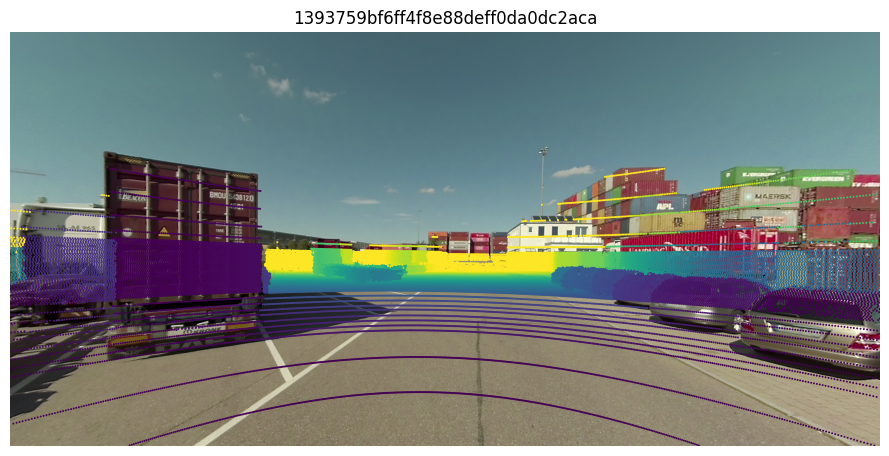

In [19]:
my_sample = trucksc.sample[3]
print(my_sample)
sensor = 'CAMERA_LEFT_FRONT'
cam_front_data = trucksc.get('sample_data', my_sample['data'][sensor])
print(cam_front_data['filename'])
trucksc.render_pointcloud_in_image(my_sample['token'], pointsensor_channel='LIDAR_LEFT', camera_channel='CAMERA_LEFT_FRONT', dot_size=2)

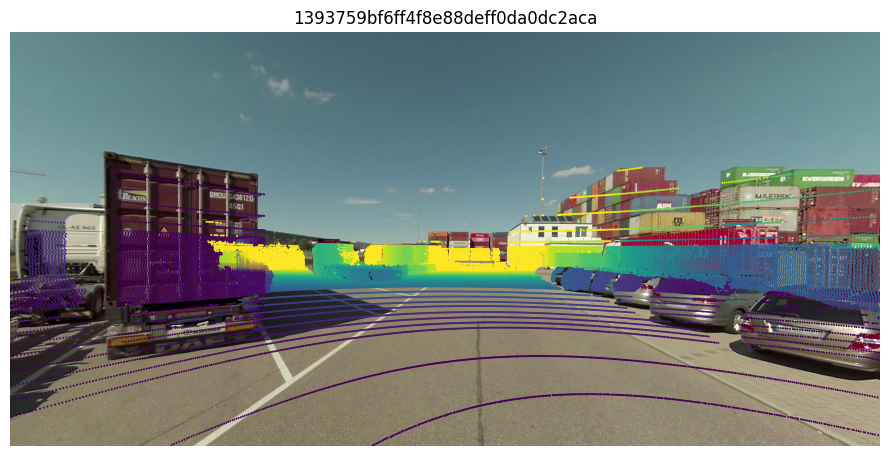

In [20]:
trucksc.render_pointcloud_in_image(my_sample['token'], pointsensor_channel='LIDAR_RIGHT', camera_channel='CAMERA_LEFT_FRONT', dot_size=2)

In [21]:
del my_sample, sensor, cam_front_data

## Dataset Preparation

In this phase, we will begin preparing our train_set and test_set by extracting images, point cloud masks, depths and descriptions of the scens from the available sensors and cameras in the dataset. For computational efficiency, we will reduce the size of the test_set to one third of its original size.

In [22]:
numberScene = [0,2,3,6,8]
numberSceneTest = [1,4,5,7,9]
sensors = ['CAMERA_LEFT_FRONT','CAMERA_RIGHT_FRONT','CAMERA_LEFT_BACK','CAMERA_RIGHT_BACK']
sensors_lidar = ['LIDAR_LEFT','LIDAR_RIGHT','LIDAR_LEFT','LIDAR_RIGHT']

In [23]:
cam_images = []
depths_asb = []
points_dep_abs = []

In [24]:
for n in numberScene:
  my_scene = trucksc.scene[n]
  first_sample_token = my_scene['first_sample_token']
  my_sample = trucksc.get('sample', first_sample_token)

  while my_sample['next'] is not None and my_sample['next'] != '':
    for sensor,lidar in zip(sensors,sensors_lidar):
      cam_data = trucksc.get('sample_data', my_sample['data'][sensor])
      image = Image.open('/content/man-truckscenes/'+cam_data['filename'])
      cam_images.append(image)
      points, _, _, depths = render_pointcloud_in_deapth(my_sample['token'], pointsensor_channel=lidar, camera_channel=sensor)
      depths_asb.append(depths)
      points_dep_abs.append(points)
    my_sample = trucksc.get('sample', my_sample['next'])

del cam_data, image, points, depths,first_sample_token, my_sample, my_scene,sensor,lidar

In [25]:
print(len(cam_images))
print(len(depths_asb))
print(len(points_dep_abs))

780
780
780


In [26]:
cam_images_test = []
depths_asb_test = []
points_dep_abs_test = []
desc_test = []

In [27]:
for n in numberSceneTest:
  my_scene = trucksc.scene[n]
  first_sample_token = my_scene['first_sample_token']
  my_sample = trucksc.get('sample', first_sample_token)

  while my_sample['next'] is not None and my_sample['next'] != '':
    for sensor,lidar in zip(sensors,sensors_lidar):
      cam_data = trucksc.get('sample_data', my_sample['data'][sensor])
      image = Image.open('/content/man-truckscenes/'+cam_data['filename'])
      cam_images_test.append(image)
      desc_test.append(my_scene['description'])
      points, _, _, depths = render_pointcloud_in_deapth(my_sample['token'], pointsensor_channel=lidar, camera_channel=sensor)
      depths_asb_test.append(depths)
      points_dep_abs_test.append(points)
    my_sample = trucksc.get('sample', my_sample['next'])
del cam_data, image, points, depths,first_sample_token, my_sample, my_scene,sensor,lidar

In [28]:
sampled_lists, sampled_indices = sample_30_percent_same_indices([cam_images_test, depths_asb_test, points_dep_abs_test,desc_test])
sampled_cam_images_test, sampled_depths_asb_test, sampled_points_dep_abs_test , sampled_desc_test = sampled_lists

print("Sampled cam_images_test length:", len(sampled_cam_images_test))
print("Sampled depths_asb_test length:", len(sampled_depths_asb_test))
print("Sampled points_dep_abs_test length:", len(sampled_points_dep_abs_test))
print("Sampled desc_test length:", len(sampled_desc_test))

cam_images_test = sampled_cam_images_test
depths_asb_test = sampled_depths_asb_test
points_dep_abs_test = sampled_points_dep_abs_test
desc_test = sampled_desc_test
del sampled_cam_images_test, sampled_depths_asb_test, sampled_points_dep_abs_test, sampled_lists, sampled_indices, sampled_desc_test

Sampled cam_images_test length: 234
Sampled depths_asb_test length: 234
Sampled points_dep_abs_test length: 234
Sampled desc_test length: 234


## Generating Relative Depth Heatmaps

The next step is to input both the train and test sets into DepthAnything2 in order to obtain the corresponding relative depth heatmaps.

In [29]:
depths_rel = []
for image in cam_images:
  inputs = image_processor(images=image, return_tensors="pt").to(device)

  with torch.no_grad():
      output = model(**inputs)
  post_processed_output = image_processor.post_process_depth_estimation(
      output,
      target_sizes=[(image.height, image.width)],
  )
  depths_rel.append(post_processed_output[0]["predicted_depth"])
  # Libera memoria GPU non più necessaria
  del inputs, output, post_processed_output
  torch.cuda.empty_cache()  # Solo se usi la GPU

In [30]:
# prepare image for the model
depths_rel_test = []

for image in cam_images_test:
  inputs = image_processor(images=image, return_tensors="pt").to(device)

  with torch.no_grad():
      output = model(**inputs)
  post_processed_output = image_processor.post_process_depth_estimation(
      output,
      target_sizes=[(image.height, image.width)],
  )
  depths_rel_test.append(post_processed_output[0]["predicted_depth"])
  # Libera memoria GPU non più necessaria
  del inputs, output, post_processed_output
  torch.cuda.empty_cache()  # Solo se usi la GPU

In [31]:
del model, image_processor

### Parameter Extraction via Polynomial Regression  
This part calculates **linear (1st-degree)** and **quadratic (2nd-degree)** polynomial coefficients (`a`, `b` or `a`, `b`, `c`) to model the relationship between relative depth values and absolute depth measurements.
This operation is done for train_Set e test_Set.

**Key Operations:**  
1. **Data Alignment**:  
   - Extracts valid (x,y) coordinates from LiDAR point clouds projected onto the depth map.  
   - Inverts relative depth values (`depth_rel = max_val - depth_rel_img`) to align with absolute depth conventions.  

2. **Filtering**:  
   - Applies masks to exclude invalid (non-finite or ≤0) depth values.  

3. **Regression**:  
   - Uses `np.polyfit` to compute optimal coefficients for:  
     - **Linear**: `D_abs ≈ a·D_rel + b`  
     - **Quadratic**: `D_abs ≈ a·D_rel² + b·D_rel + c`  

**Output**:  
- Stores coefficients in `params_depth` for later use in depth transformation tasks.

In [32]:
params_depth = []
for depth_rel_img, points, depth_abs in zip(depths_rel, points_dep_abs, depths_asb):
    xs = points[0].astype(int)
    ys = points[1].astype(int)

    depth_rel_inv = depth_rel_img
    depth_rel = depth_rel_inv.max() - depth_rel_inv

    depth_rel_pts = depth_rel[ys, xs]
    Dabs_tensor = torch.from_numpy(depth_abs).float().to(depth_rel_pts.device)


    mask = (depth_rel_pts > 0) & torch.isfinite(depth_rel_pts)
    Drel = depth_rel_pts[mask]
    Dabs = Dabs_tensor[mask]


    a, b = np.polyfit(Drel.cpu().numpy(), Dabs.cpu().numpy(), 1)
    params_depth.append((a, b))
del depth_rel_img, points, depth_abs, xs, ys, depth_rel_inv, depth_rel, depth_rel_pts, Dabs_tensor, mask, Drel, Dabs

In [33]:
params_depth_train_3d = []
for depth_rel_img, points, depth_abs in zip(depths_rel, points_dep_abs, depths_asb):
    xs = points[0].astype(int)
    ys = points[1].astype(int)

    depth_rel_inv = depth_rel_img
    depth_rel = depth_rel_inv.max() - depth_rel_inv

    depth_rel_pts = depth_rel[ys, xs]
    Dabs_tensor = torch.from_numpy(depth_abs).float().to(depth_rel_pts.device)


    mask = (depth_rel_pts > 0) & torch.isfinite(depth_rel_pts)
    Drel = depth_rel_pts[mask]
    Dabs = Dabs_tensor[mask]


    a, b, c = np.polyfit(Drel.cpu().numpy(), Dabs.cpu().numpy(), 2)
    params_depth_train_3d.append((a, b,c))
del depth_rel_img, points, depth_abs, xs, ys, depth_rel_inv, depth_rel, depth_rel_pts, Dabs_tensor, mask, Drel, Dabs

In [34]:
params_depth_test = []
for depth_rel_img, points, depth_abs in zip(depths_rel_test, points_dep_abs_test, depths_asb_test):
    xs = points[0].astype(int)
    ys = points[1].astype(int)

    depth_rel_inv = depth_rel_img
    depth_rel = depth_rel_inv.max() - depth_rel_inv

    depth_rel_pts = depth_rel[ys, xs]
    Dabs_tensor = torch.from_numpy(depth_abs).float().to(depth_rel_pts.device)


    mask = (depth_rel_pts > 0) & torch.isfinite(depth_rel_pts)
    Drel = depth_rel_pts[mask]
    Dabs = Dabs_tensor[mask]


    a, b = np.polyfit(Drel.cpu().numpy(), Dabs.cpu().numpy(), 1)
    params_depth_test.append((a, b))
del depth_rel_img, points, depth_abs, xs, ys, depth_rel_inv, depth_rel, depth_rel_pts, Dabs_tensor, mask, Drel, Dabs

In [35]:
params_depth_test_3d = []
for depth_rel_img, points, depth_abs in zip(depths_rel_test, points_dep_abs_test, depths_asb_test):
    xs = points[0].astype(int)
    ys = points[1].astype(int)

    depth_rel_inv = depth_rel_img
    depth_rel = depth_rel_inv.max() - depth_rel_inv

    depth_rel_pts = depth_rel[ys, xs]
    Dabs_tensor = torch.from_numpy(depth_abs).float().to(depth_rel_pts.device)


    mask = (depth_rel_pts > 0) & torch.isfinite(depth_rel_pts)
    Drel = depth_rel_pts[mask]
    Dabs = Dabs_tensor[mask]


    a, b, c = np.polyfit(Drel.cpu().numpy(), Dabs.cpu().numpy(), 2)
    params_depth_test_3d.append((a, b,c))
del depth_rel_img, points, depth_abs, xs, ys, depth_rel_inv, depth_rel, depth_rel_pts, Dabs_tensor, mask, Drel, Dabs

## Model Training Setup and Execution

### **Implementation Steps**  
#### 1. **Hardware Configuration**  
   - Automatically selects GPU (`cuda`) if available, otherwise uses CPU

#### 2. **Model Initialization**  
   - Instantiates `ScaleBiasHead` (multi-scale fusion + SEBlocks)  
   - Moves model to selected device (GPU/CPU)

#### 3. **Optimizer Configuration**  
   - Adam optimizer with learning rate: $\alpha = 0.001$

#### 4. **Training Process** (`train_in_batches`)  
   - **Input Data Batches**:  
     - RGB images (`cam_images`)  
     - Relative depth maps (`depths_rel`)  
     - LiDAR projections (`points_dep_abs`, `depths_asb`)  
     - Polynomial coefficients (`params_depth_train_3d`)
   - **Batch Processing**:  
     - Batch size = 4 (memory-constrained)  
     - Input: Concatenated RGB + depth channels  
     - Training duration: 100 epochs
  

### 5. Hybrid Loss Components

**Depth Loss (MSE):**

$$
\mathcal{L}_{\text{depth}} = \frac{1}{N}\sum_{i=1}^N \left(D_{\text{pred}}^{(i)} - D_{\text{abs}}^{(i)}\right)^2
$$

Where:

- $D_{\text{pred}}^{(i)}$ = Model-predicted depth  
- $D_{\text{abs}}^{(i)}$ = LiDAR-measured depth  
- $N$ = Number of valid LiDAR points  

**Parameter Loss (Huber):**

$$
\mathcal{L}_{\text{param}} = \frac{1}{B}\sum_{j=1}^B \sum_{k\in\{a,b,c\}}
\begin{cases}
0.5\Delta^2 & \text{if } |\hat{k}_j - k_j| \leq \Delta \\
\Delta(|\hat{k}_j - k_j| - 0.5\Delta) & \text{otherwise}
\end{cases}
$$

Where:

- $\hat{k}_j$ = Predicted parameters  
- $k_j$ = Polynomial parameters  
- $\Delta = 1.0$  

**Total Loss:**

$$
\mathcal{L}_{\text{total}} = \mathcal{L}_{\text{depth}} + 0.5\mathcal{L}_{\text{param}}
$$




**Purpose**  
Trains model to predict optimal affine parameters $(a,b,c)$ that:  
1. Minimize depth prediction error vs LiDAR measurements  
2. Maintain physical plausibility through polynomial constraints


In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_Scale = ScaleBiasHead().to(device)
optimizer = optim.AdamW(model_Scale.parameters(), lr=1e-3, weight_decay=1e-4)


train_in_batches(
    cam_images, depths_rel, points_dep_abs, depths_asb,params_depth_train_3d,
    cam_images_test, depths_rel_test, points_dep_abs_test, depths_asb_test,
    model_Scale, optimizer, num_epochs=70, batch_size=8, device=device,patience=5
)

Epoch 1/50, Loss: 673.3680
 Loss: 861.8545
Epoch 2/50, Loss: 594.8069
 Loss: 741.2268
Epoch 3/50, Loss: 576.9310
 Loss: 650.3464
Epoch 4/50, Loss: 572.3329
 Loss: 658.4399
Epoch 5/50, Loss: 533.9605
 Loss: 667.8279
Epoch 6/50, Loss: 529.3473
 Loss: 628.7716


KeyboardInterrupt: 

In [ ]:
del cam_images, depths_asb, points_dep_abs

## Evaluation
This section of the notebook evaluates and compares the performance of different depth transformation approaches on the test set.

- The function `test_in_batches` is used to generate the predicted affine parameters (a, b, c) for each test sample using the trained model. The average test loss for the model’s predictions is printed after one epoch, indicating the model’s overall error in transforming relative to absolute depth values.

- Next, two baseline comparisons are performed using polynomial regression:
  - For the linear case (2D Polyfit), the parameters obtained from fitting a first-degree polynomial to the data are converted to tensors and evaluated using the `affine_depth_loss_2d` function. The resulting loss quantifies how well a simple linear transformation fits the test data.
  - For the quadratic case (3D Polyfit), the second-degree polynomial parameters are similarly tested with the `affine_depth_loss` function, and the corresponding loss is printed.

- By reporting the test losses for the model, the 2D polyfit, and the 3D polyfit, this part enables a direct comparison between the learned model’s predictions and the best possible polynomial fits, highlighting the accuracy and potential advantages of the model over traditional regression approaches.


In [ ]:
a_b_c_test,_ = test_in_batches(
    cam_images_test, depths_rel_test, points_dep_abs_test, depths_asb_test,
    model_Scale, batch_size=1, device=device
)

In [ ]:
target_a_b_tensor = torch.tensor(params_depth_test, dtype=torch.float32).to(device)
loss = affine_depth_loss_2d(target_a_b_tensor, depths_rel_test, points_dep_abs_test,depths_asb_test)
print(f"Test Loss with 2D Polyfit : {loss.item():.4f}")

In [ ]:
target_a_b_c_tensor = torch.tensor(params_depth_test_3d, dtype=torch.float32).to(device)
loss = affine_depth_loss(target_a_b_c_tensor, depths_rel_test, points_dep_abs_test,depths_asb_test)
print(f"Test Loss with 3D Polyfit : {loss.item():.4f}")

## Evaluation in different condition
This section of the notebook evaluates model performance under specific lighting conditions—here, for the "illuminated" subset, but the same approach is repeated for "dark" and "other_lighting" conditions.

- The dataset is first filtered to select only the samples with the desired lighting condition (e.g., "illuminated").
- The number of filtered samples is checked, and if present, the evaluation proceeds.
- The trained model predicts affine depth transformation parameters on the filtered test set using `test_in_batches`, and the test loss is reported.
- For comparison, the loss is also computed using the best-fit linear (2D polyfit) and quadratic (3D polyfit) polynomial parameters for the same data, using the respective loss functions.
- All results are printed, allowing direct comparison of the model’s performance against the polynomial baselines for each lighting condition.

This process enables a detailed analysis of how well the model and polynomial baselines perform under different lighting scenarios, highlighting strengths and weaknesses in varying real-world conditions.

In [ ]:
(cam_images_ill, depths_rel_ill, desc_ill,
 points_dep_abs_ill, depths_asb_ill, params_depth_ill, params_depth_ill_3d, a_b_c_test_i) = filter_by_lighting(
    "illuminated",
    cam_images_test, depths_rel_test, desc_test,
    points_dep_abs_test, depths_asb_test, params_depth_test, params_depth_test_3d, a_b_c_test
)

In [ ]:
len(cam_images_ill)

In [ ]:
if len(cam_images_ill) > 0:
  print("Condition : Illuminated")

    # Stack the list of tensors into a single batch tensor
  target_a_b_c_tensor_i = torch.stack(a_b_c_test_i).to(device)
  loss = affine_depth_loss(target_a_b_c_tensor_i, depths_rel_ill, points_dep_abs_ill,depths_asb_ill)
  print(f"Test Loss with 3D Model : {loss.item():.4f}")
  target_a_b_tensor_i = torch.tensor(params_depth_ill, dtype=torch.float32).to(device)
  loss = affine_depth_loss_2d(target_a_b_tensor_i, depths_rel_ill, points_dep_abs_ill,depths_asb_ill)
  print(f"Test Loss with 2D Polyfit : {loss.item():.4f}")
  target_a_b_c_tensor_i = torch.tensor(params_depth_ill_3d, dtype=torch.float32).to(device)
  loss = affine_depth_loss(target_a_b_c_tensor_i, depths_rel_ill, points_dep_abs_ill,depths_asb_ill)
  print(f"Test Loss with 3D Polyfit : {loss.item():.4f}")

In [ ]:
(cam_images_d, depths_rel_d, desc_d,
 points_dep_abs_d, depths_asb_d, params_depth_d, params_depth_d_3d, a_b_c_test_d) = filter_by_lighting(
    "dark",
    cam_images_test, depths_rel_test, desc_test,
    points_dep_abs_test, depths_asb_test, params_depth_test, params_depth_test_3d, a_b_c_test
)

In [ ]:
len(cam_images_d)

In [ ]:
if len(cam_images_d) > 0:
  print("Condition : Dark")

  target_a_b_c_tensor_d = torch.stack(a_b_c_test_i).to(device)
  loss = affine_depth_loss(target_a_b_c_tensor_d, depths_rel_ill, points_dep_abs_ill,depths_asb_ill)
  print(f"Test Loss with 3D Model : {loss.item():.4f}")
  target_a_b_tensor_d = torch.tensor(params_depth_d, dtype=torch.float32).to(device)
  loss = affine_depth_loss_2d(target_a_b_tensor_d, depths_rel_d, points_dep_abs_d,depths_asb_d)
  print(f"Test Loss with 2D Polyfit : {loss.item():.4f}")
  target_a_b_c_tensor_d = torch.tensor(params_depth_d_3d, dtype=torch.float32).to(device)
  loss = affine_depth_loss(target_a_b_c_tensor_d, depths_rel_d, points_dep_abs_d,depths_asb_d)
  print(f"Test Loss with 3D Polyfit : {loss.item():.4f}")

In [ ]:
(cam_images_o, depths_rel_o, desc_o,
 points_dep_abs_o, depths_asb_o, params_depth_o, params_depth_o_3d, a_b_c_test_o) = filter_by_lighting(
    "other_lighting",
    cam_images_test, depths_rel_test, desc_test,
    points_dep_abs_test, depths_asb_test, params_depth_test, params_depth_test_3d, a_b_c_test
)


In [ ]:
len(cam_images_o)

In [ ]:
if len(cam_images_o) > 0:
  print("Condition : Other_lighting")
  target_a_b_c_tensor_o = torch.stack(a_b_c_test_i).to(device)
  loss = affine_depth_loss(target_a_b_c_tensor_o, depths_rel_ill, points_dep_abs_ill,depths_asb_ill)
  print(f"Test Loss with 3D Model : {loss.item():.4f}")
  target_a_b_tensor_o = torch.tensor(params_depth_o, dtype=torch.float32).to(device)
  loss = affine_depth_loss_2d(target_a_b_tensor_o, depths_rel_o, points_dep_abs_o,depths_asb_o)
  print(f"Test Loss with 2D Polyfit : {loss.item():.4f}")
  target_a_b_c_tensor_o = torch.tensor(params_depth_o_3d, dtype=torch.float32).to(device)
  loss = affine_depth_loss(target_a_b_c_tensor_o, depths_rel_o, points_dep_abs_o,depths_asb_o)
  print(f"Test Loss with 3D Polyfit : {loss.item():.4f}")

## Tangible Evaluation Pipeline  
This phase transitions from abstract loss metrics to **physically interpretable depth accuracy measures** by combining object detection (YOLO) with depth transformation analysis.  

**Process Flow:**  
1. **Bounding Box Generation** (`test_yolo_in_batches`):  
   - YOLO detects objects and outputs bounding boxes for each test image.  
   - For each box, two depth estimates are computed:  
     - **Model-Predicted**: Using learned affine parameters (`a,b,c`) from `ScaleBiasHead`.  
     - **Polynomial-Estimated**: Using precomputed quadratic/linear coefficients from `polyfit`.  

2. **Error Quantification** (`extract_comparison_stats`):  
   - For every bounding box, three metrics are calculated:  
     - **Mean Depth Error**: Absolute difference (meters) between model/polynomial estimates and LiDAR-measured ground truth.  
     - **Per-Point Error**: Error normalized by the number of LiDAR points in the box (accounts for sparse/dense measurements).  
     - **Box Overlap (IoU)**: Intersection-over-Union with ground-truth boxes (if available).  

**Key Metrics Reported:**  
- model_vs_abs_stats_mean: This metric represents the average error of the model's depth predictions compared to LiDAR ground truth, measured in meters. It provides an overall indication of the model's depth accuracy.

- poly_vs_abs_stats_mean: This metric shows the average error of the polynomial baseline's depth estimates compared to LiDAR measurements. It is used to compare the model's performance against traditional regression methods.

- box_stats: num_points: This indicates the number of LiDAR points contained within each bounding box. It serves as a reliability indicator for the depth measurements, as more points generally mean more reliable data.

- diff_transformed_per_point: This metric measures the difference in depth error per LiDAR point between the model's predictions and the polynomial baseline. It helps analyze the effectiveness of the model's affine parameter predictions compared to the polynomial approach.

**Advantages Over Loss Metrics:**  
- **Interpretability**: Errors in meters (e.g., "model is 0.45m more accurate than polynomial on snow scenes").  
- **Detection-Aware**: Ties depth errors to specific objects (e.g., trucks vs signs).  
- **Scenario Breakdown**: Enables per-condition analysis (lighting, weather) via `filter_by_lighting`.  



In [ ]:
yolo = YOLO("yolo11n.pt")
distances = test_yolo_in_batches(
    cam_images_test, depths_rel_test, points_dep_abs_test, depths_asb_test,
     a_b_c_test,params_depth_test_3d, yolo,device)
distances_ill = test_yolo_in_batches(
    cam_images_ill, depths_rel_ill, points_dep_abs_ill, depths_asb_ill,
     a_b_c_test_i,params_depth_ill_3d, yolo,device)
distances_d = test_yolo_in_batches(
    cam_images_d, depths_rel_d, points_dep_abs_d, depths_asb_d,
     a_b_c_test_d,params_depth_d_3d, yolo,device)
distances_o = test_yolo_in_batches(
    cam_images_o, depths_rel_o, points_dep_abs_o, depths_asb_o,
     a_b_c_test_o,params_depth_o_3d, yolo,device)

In [ ]:
stats,comparison_stats,comparison_stats_boxes = extract_comparison_stats(distances)
stats_ill,comparison_stats_ill,comparison_stats_ill_boxes = extract_comparison_stats(distances_ill)
stats_d,comparison_stats_d,comparison_stats_ill_d = extract_comparison_stats(distances_d)
stats_o,comparison_stats_o,comparison_stats_ill_o = extract_comparison_stats(distances_o)

In [ ]:
print("Stats of all test_set: ")
print(stats)
print("Stats of Illuminated test_set: ")
print(stats_ill)
print("Stats of Dark test_set: ")
print(stats_d)
print("Stats of Other_lighting test_set: ")
print(stats_o)

In [ ]:
plot_stats_vs_num_points(comparison_stats_boxes)

In [ ]:
plot_stats_vs_num_points(comparison_stats_ill_boxes)

In [ ]:
plot_stats_vs_num_points(comparison_stats_ill_d)

In [ ]:
plot_stats_vs_num_points(comparison_stats_ill_o)

In [ ]:
if len(comparison_stats_boxes) > 0:
  plot_comparison_curves(comparison_stats_boxes)

In [ ]:
if len(comparison_stats_ill_boxes) > 0:
  plot_comparison_curves(comparison_stats_ill_boxes)

In [ ]:
if len(comparison_stats_ill_d) > 0:
  plot_comparison_curves(comparison_stats_ill_d)

In [ ]:
if len(comparison_stats_ill_o) > 0:
  plot_comparison_curves(comparison_stats_ill_o)

In [ ]:
if len(comparison_stats) > 0:
  print("One element of all dataset")
  print_comparison_stats(comparison_stats[0])

In [ ]:
if len(comparison_stats_ill) > 0:
  print("One element of Illuminated part of dataset")
  print_comparison_stats(comparison_stats_ill[0])

In [ ]:
if len(comparison_stats_d) > 0:
  print("One element of Dark part of dataset")
  print_comparison_stats(comparison_stats_d[0])

In [ ]:
if len(comparison_stats_o) > 0:
  print("One element of Other_lighting part of dataset")
  print_comparison_stats(comparison_stats_o[0])

## Plotting
In this final section, I present a clear, visual, and quantitative summary of the results obtained on a single randomly selected image from the test set. This includes:

- Displaying the image with detected bounding boxes and annotated depth information.
- Showing the corresponding depth heatmap.
- Overlaying LiDAR point cloud data for visual reference.
- Reporting key evaluation metrics for that image, such as model and baseline errors.

This approach provides an intuitive, example-driven understanding of the model’s performance, making the results more tangible and interpretable.

### First Plot

In [ ]:
num = random.randint(0,len(cam_images_test))
transform = ToTensor()

# Estrai il singolo elemento
single_rgb_image = cam_images_test[num]
single_depth_rel = depths_rel_test[num]
single_depth_abs = depths_asb_test[num]
single_points_dep_abs = points_dep_abs_test[num]
single_depths_asb = depths_asb_test[num]
single_desc = desc_test[num]

# Preprocessing immagine RGB
rgb_tensor = transform(single_rgb_image).to(device)
# Add batch dimension for single image
rgb_batch = rgb_tensor.unsqueeze(0) # (1, 3, H, W)

# Preprocessing depth relative (ensure it's a tensor on the correct device)
if not isinstance(single_depth_rel, torch.Tensor):
    d_rel_tensor = torch.tensor(single_depth_rel).float().to(device)
else:
    d_rel_tensor = single_depth_rel.float().to(device)

# Add batch dimension for single depth map
d_rel_batch = d_rel_tensor.unsqueeze(0).unsqueeze(1) # (1, 1, H, W)

# Concatenazione (this results in 4 channels)
input_tensor = torch.cat([rgb_batch, d_rel_batch], dim=1)


In [ ]:
print(single_desc)

In [ ]:
model_Scale.eval()
with torch.no_grad():
    a_b_c = model_Scale(input_tensor)

# Calculate the loss using the predicted a_b and the original data
loss = affine_depth_loss(a_b_c, [depths_rel_test[num]], [points_dep_abs_test[num]], [depths_asb_test[num]])
print(f"Test Loss: {loss.item():.4f}")

In [ ]:
target_a_b_tensor = torch.tensor([params_depth_test[num]], dtype=torch.float32).to(device)
loss = affine_depth_loss_2d(target_a_b_tensor, [depths_rel_test[num]], [points_dep_abs_test[num]], [depths_asb_test[num]])
print(f"Test Loss with 3D Polyfit : {loss.item():.4f}")

In [ ]:
target_a_b_c_tensor = torch.tensor([params_depth_test_3d[num]], dtype=torch.float32).to(device)
loss = affine_depth_loss(target_a_b_c_tensor, [depths_rel_test[num]], [points_dep_abs_test[num]], [depths_asb_test[num]])
print(f"Test Loss with 3D Polyfit : {loss.item():.4f}")

In [ ]:
depthScaled = scaleDepthTo255(single_depth_rel)
plt.imshow(depthScaled)
a_b_c_t = a_b_c.cpu().numpy()
a = a_b_c_t[0][0]
b = a_b_c_t[0][1]
c = a_b_c_t[0][2]
a_poly = params_depth_test[num][0]
b_poly = params_depth_test[num][1]
a_poly_3d = params_depth_test_3d[num][0]
b_poly_3d = params_depth_test_3d[num][1]
c_poly_3d = params_depth_test_3d[num][2]

In [ ]:
results = yolo(single_rgb_image)
results[0].show()

In [ ]:
input_boxs = []
for result in results[0]:
  boxes_tensor = result.boxes.xyxy

  # Converti in NumPy array
  boxes_np = boxes_tensor.cpu().detach().numpy()

  # Se ti serve solo il primo box, ad esempio:
  input_box = boxes_np[0]

  input_boxs.append(input_box)

In [ ]:
plot_with_box_depth(single_rgb_image,single_depth_rel.detach().cpu().numpy(),input_boxs,
    a=a_poly,
    b=b_poly)

In [ ]:
plot_with_box_depth_3d(single_rgb_image,single_depth_rel.detach().cpu().numpy(),input_boxs,
    a=a_poly_3d,
    b=b_poly_3d,
    c=c_poly_3d)

In [ ]:
plot_with_box_depth_3d(single_rgb_image,single_depth_rel.detach().cpu().numpy(),input_boxs,
    a=a,
    b=b,
    c=c)

In [ ]:
plot_with_box_depth2(single_rgb_image,single_depth_rel.detach().cpu().numpy(),input_boxs,
    a=a_poly,
    b=b_poly)

In [ ]:
plot_with_box_depth3(single_rgb_image,single_depth_rel.detach().cpu().numpy(),input_boxs,
    a=a_poly_3d,
    b=b_poly_3d,
    c=c_poly_3d)

In [ ]:
plot_with_box_depth3(single_rgb_image,single_depth_rel.detach().cpu().numpy(),input_boxs,
    a=a,
    b=b,
    c=c)

In [ ]:
plot_with_box_depth_rel_abs(image= single_rgb_image, depth_rel= single_depth_rel.detach().cpu().numpy(),
                        input_boxes= input_boxs,
                        a=a,
                        b=b,
                        c=c,
                        points_dep_abs=single_points_dep_abs,
                        depths_abs=single_depths_asb)

In [ ]:
plot_with_box_depth_rel_abs(image= single_rgb_image, depth_rel= single_depth_rel.detach().cpu().numpy(),
                        input_boxes= input_boxs,
                        a=a_poly_3d,
                        b=b_poly_3d,
                        c=c_poly_3d,
                        points_dep_abs=single_points_dep_abs,
                        depths_abs=single_depths_asb)

### Second Plot

In [ ]:
num = random.randint(0,len(cam_images_test))
transform = ToTensor()

# Estrai il singolo elemento
single_rgb_image = cam_images_test[num]
single_depth_rel = depths_rel_test[num]
single_depth_abs = depths_asb_test[num]
single_points_dep_abs = points_dep_abs_test[num]
single_depths_asb = depths_asb_test[num]
single_desc = desc_test[num]

# Preprocessing immagine RGB
rgb_tensor = transform(single_rgb_image).to(device)
# Add batch dimension for single image
rgb_batch = rgb_tensor.unsqueeze(0) # (1, 3, H, W)

# Preprocessing depth relative (ensure it's a tensor on the correct device)
if not isinstance(single_depth_rel, torch.Tensor):
    d_rel_tensor = torch.tensor(single_depth_rel).float().to(device)
else:
    d_rel_tensor = single_depth_rel.float().to(device)

# Add batch dimension for single depth map
d_rel_batch = d_rel_tensor.unsqueeze(0).unsqueeze(1) # (1, 1, H, W)

# Concatenazione (this results in 4 channels)
input_tensor = torch.cat([rgb_batch, d_rel_batch], dim=1)


In [ ]:
print(single_desc)

In [ ]:
model_Scale.eval()
with torch.no_grad():
    a_b_c = model_Scale(input_tensor)

# Calculate the loss using the predicted a_b and the original data
loss = affine_depth_loss(a_b_c, [depths_rel_test[num]], [points_dep_abs_test[num]], [depths_asb_test[num]])
print(f"Test Loss: {loss.item():.4f}")

In [ ]:
target_a_b_tensor = torch.tensor([params_depth_test[num]], dtype=torch.float32).to(device)
loss = affine_depth_loss_2d(target_a_b_tensor, [depths_rel_test[num]], [points_dep_abs_test[num]], [depths_asb_test[num]])
print(f"Test Loss with 3D Polyfit : {loss.item():.4f}")

In [ ]:
target_a_b_c_tensor = torch.tensor([params_depth_test_3d[num]], dtype=torch.float32).to(device)
loss = affine_depth_loss(target_a_b_c_tensor, [depths_rel_test[num]], [points_dep_abs_test[num]], [depths_asb_test[num]])
print(f"Test Loss with 3D Polyfit : {loss.item():.4f}")

In [ ]:
depthScaled = scaleDepthTo255(single_depth_rel)
plt.imshow(depthScaled)
a_b_c_t = a_b_c.cpu().numpy()
a = a_b_c_t[0][0]
b = a_b_c_t[0][1]
c = a_b_c_t[0][2]
a_poly = params_depth_test[num][0]
b_poly = params_depth_test[num][1]
a_poly_3d = params_depth_test_3d[num][0]
b_poly_3d = params_depth_test_3d[num][1]
c_poly_3d = params_depth_test_3d[num][2]

In [ ]:
results = yolo(single_rgb_image)
results[0].show()

In [ ]:
input_boxs = []
for result in results[0]:
  boxes_tensor = result.boxes.xyxy

  # Converti in NumPy array
  boxes_np = boxes_tensor.cpu().detach().numpy()

  # Se ti serve solo il primo box, ad esempio:
  input_box = boxes_np[0]

  input_boxs.append(input_box)

In [ ]:
plot_with_box_depth(single_rgb_image,single_depth_rel.detach().cpu().numpy(),input_boxs,
    a=a_poly,
    b=b_poly)

In [ ]:
plot_with_box_depth_3d(single_rgb_image,single_depth_rel.detach().cpu().numpy(),input_boxs,
    a=a_poly_3d,
    b=b_poly_3d,
    c=c_poly_3d)

In [ ]:
plot_with_box_depth_3d(single_rgb_image,single_depth_rel.detach().cpu().numpy(),input_boxs,
    a=a,
    b=b,
    c=c)

In [ ]:
plot_with_box_depth2(single_rgb_image,single_depth_rel.detach().cpu().numpy(),input_boxs,
    a=a_poly,
    b=b_poly)

In [ ]:
plot_with_box_depth3(single_rgb_image,single_depth_rel.detach().cpu().numpy(),input_boxs,
    a=a_poly_3d,
    b=b_poly_3d,
    c=c_poly_3d)

In [ ]:
plot_with_box_depth3(single_rgb_image,single_depth_rel.detach().cpu().numpy(),input_boxs,
    a=a,
    b=b,
    c=c)

In [ ]:
plot_with_box_depth_rel_abs(image= single_rgb_image, depth_rel= single_depth_rel.detach().cpu().numpy(),
                        input_boxes= input_boxs,
                        a=a,
                        b=b,
                        c=c,
                        points_dep_abs=single_points_dep_abs,
                        depths_abs=single_depths_asb)

In [ ]:
plot_with_box_depth_rel_abs(image= single_rgb_image, depth_rel= single_depth_rel.detach().cpu().numpy(),
                        input_boxes= input_boxs,
                        a=a_poly_3d,
                        b=b_poly_3d,
                        c=c_poly_3d,
                        points_dep_abs=single_points_dep_abs,
                        depths_abs=single_depths_asb)

### Third Plot

In [ ]:
num = random.randint(0,len(cam_images_test))
transform = ToTensor()

# Estrai il singolo elemento
single_rgb_image = cam_images_test[num]
single_depth_rel = depths_rel_test[num]
single_depth_abs = depths_asb_test[num]
single_points_dep_abs = points_dep_abs_test[num]
single_depths_asb = depths_asb_test[num]
single_desc = desc_test[num]

# Preprocessing immagine RGB
rgb_tensor = transform(single_rgb_image).to(device)
# Add batch dimension for single image
rgb_batch = rgb_tensor.unsqueeze(0) # (1, 3, H, W)

# Preprocessing depth relative (ensure it's a tensor on the correct device)
if not isinstance(single_depth_rel, torch.Tensor):
    d_rel_tensor = torch.tensor(single_depth_rel).float().to(device)
else:
    d_rel_tensor = single_depth_rel.float().to(device)

# Add batch dimension for single depth map
d_rel_batch = d_rel_tensor.unsqueeze(0).unsqueeze(1) # (1, 1, H, W)

# Concatenazione (this results in 4 channels)
input_tensor = torch.cat([rgb_batch, d_rel_batch], dim=1)


In [ ]:
print(single_desc)

In [ ]:
model_Scale.eval()
with torch.no_grad():
    a_b_c = model_Scale(input_tensor)

# Calculate the loss using the predicted a_b and the original data
loss = affine_depth_loss(a_b_c, [depths_rel_test[num]], [points_dep_abs_test[num]], [depths_asb_test[num]])
print(f"Test Loss: {loss.item():.4f}")

In [ ]:
target_a_b_tensor = torch.tensor([params_depth_test[num]], dtype=torch.float32).to(device)
loss = affine_depth_loss_2d(target_a_b_tensor, [depths_rel_test[num]], [points_dep_abs_test[num]], [depths_asb_test[num]])
print(f"Test Loss with 3D Polyfit : {loss.item():.4f}")

In [ ]:
target_a_b_c_tensor = torch.tensor([params_depth_test_3d[num]], dtype=torch.float32).to(device)
loss = affine_depth_loss(target_a_b_c_tensor, [depths_rel_test[num]], [points_dep_abs_test[num]], [depths_asb_test[num]])
print(f"Test Loss with 3D Polyfit : {loss.item():.4f}")

In [ ]:
depthScaled = scaleDepthTo255(single_depth_rel)
plt.imshow(depthScaled)
a_b_c_t = a_b_c.cpu().numpy()
a = a_b_c_t[0][0]
b = a_b_c_t[0][1]
c = a_b_c_t[0][2]
a_poly = params_depth_test[num][0]
b_poly = params_depth_test[num][1]
a_poly_3d = params_depth_test_3d[num][0]
b_poly_3d = params_depth_test_3d[num][1]
c_poly_3d = params_depth_test_3d[num][2]

In [ ]:
results = yolo(single_rgb_image)
results[0].show()

In [ ]:
input_boxs = []
for result in results[0]:
  boxes_tensor = result.boxes.xyxy

  # Converti in NumPy array
  boxes_np = boxes_tensor.cpu().detach().numpy()

  # Se ti serve solo il primo box, ad esempio:
  input_box = boxes_np[0]

  input_boxs.append(input_box)

In [ ]:
plot_with_box_depth(single_rgb_image,single_depth_rel.detach().cpu().numpy(),input_boxs,
    a=a_poly,
    b=b_poly)

In [ ]:
plot_with_box_depth_3d(single_rgb_image,single_depth_rel.detach().cpu().numpy(),input_boxs,
    a=a_poly_3d,
    b=b_poly_3d,
    c=c_poly_3d)

In [ ]:
plot_with_box_depth_3d(single_rgb_image,single_depth_rel.detach().cpu().numpy(),input_boxs,
    a=a,
    b=b,
    c=c)

In [ ]:
plot_with_box_depth2(single_rgb_image,single_depth_rel.detach().cpu().numpy(),input_boxs,
    a=a_poly,
    b=b_poly)

In [ ]:
plot_with_box_depth3(single_rgb_image,single_depth_rel.detach().cpu().numpy(),input_boxs,
    a=a_poly_3d,
    b=b_poly_3d,
    c=c_poly_3d)

In [ ]:
plot_with_box_depth3(single_rgb_image,single_depth_rel.detach().cpu().numpy(),input_boxs,
    a=a,
    b=b,
    c=c)

In [ ]:
plot_with_box_depth_rel_abs(image= single_rgb_image, depth_rel= single_depth_rel.detach().cpu().numpy(),
                        input_boxes= input_boxs,
                        a=a,
                        b=b,
                        c=c,
                        points_dep_abs=single_points_dep_abs,
                        depths_abs=single_depths_asb)

In [ ]:
plot_with_box_depth_rel_abs(image= single_rgb_image, depth_rel= single_depth_rel.detach().cpu().numpy(),
                        input_boxes= input_boxs,
                        a=a_poly_3d,
                        b=b_poly_3d,
                        c=c_poly_3d,
                        points_dep_abs=single_points_dep_abs,
                        depths_abs=single_depths_asb)